# Multilayer Perceptron (MLP) #

**Contextualização**

Neste notebook fazemos a abordagem ao problema apresentado no projeto, utilizando o *classifier* baseado no *multilayer perceptron* (MLP).

> **NOTA:**

Ao longo do notebook fazemos alterações às funções definidas. Por este motivo, o código final (para ser executado) encontra-se no separador **ANÁLISE FINAL**.


**Bibliotecas Necessárias:**

In [ ]:
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder,  StandardScaler
from tensorflow.keras.layers import BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tqdm import tqdm

Começamos por definir uma implementação básica do modelo MLP.

Inicialmente, definimos a função *preprocess_dataset* para o processamento de dados.

In [ ]:
def preprocess_dataset(dataset_path, train_folds, test_folds, val_folds, num_classes=10):
    
    # Carregar o dataset
    with open(dataset_path, 'rb') as file:
        dataset_mlp = pickle.load(file)

    # Converter para array numpy e verificar a forma
    dataset_mlp = np.array(dataset_mlp)
    print(f"Shape do dataset: {dataset_mlp.shape}")

    # Inicializar listas necessárias para o treino, teste e validação
    X_train, y_train = [], []
    X_test, y_test = [], []
    X_val, y_val = [], []

    # Preencher dados de treino
    for fold_idx in train_folds:
        data, labels = dataset_mlp[fold_idx]
        X_train.extend(data)
        y_train.extend(labels)

    # Preencher dados de teste
    for fold_idx in test_folds:
        data, labels = dataset_mlp[fold_idx]
        X_test.extend(data)
        y_test.extend(labels)

    # Preencher dados de validação
    for fold_idx in val_folds:
        data, labels = dataset_mlp[fold_idx]
        X_val.extend(data)
        y_val.extend(labels)

    # Converter para arrays numpy 
    X_train = np.array(X_train).astype(float)
    y_train = np.array(y_train)
    X_test = np.array(X_test).astype(float)
    y_test = np.array(y_test)
    X_val = np.array(X_val).astype(float)
    y_val = np.array(y_val)

    # Codificar as labels como inteiros
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    y_val = encoder.transform(y_val)

    # Normalizar as features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    print(f"Shape de X_train: {X_train.shape}")
    print(f"Shape de X_test: {X_test.shape}")
    print(f"Shape de X_val: {X_val.shape}")

    return X_train, y_train, X_test, y_test, X_val, y_val


Posteriormente, definimos a função *create_mlp* que cria um modelo MLP com:
  - Input layer: camada sem função de ativação;
  - 2 Hidden Layers: a primeira com 128 e a segunda com 64 neurónios. Para ambas as camadas utilizamos a função de ativação *relu*;
  - Output Layer: usamos o *softmax* como função de ativação.

Decidimos também implementar um modelo bastante mais simples (através da função *simpler_mlp*), com o mesmo número de camadas e respetivas funções de ativação, mas apenas com 32 e 16 neurónios para as hidden layers.

> **NOTA** \
Até ao final do projeto, todas as alterações realizadas foram aplicadas às duas funções (*create_mlp* e *simpler_mlp*), pois quisemos garantir que cada modificação fosse testada em ambos os modelos, avaliando o seu impacto tanto no modelo mais simples quanto no mais complexo. 

Após treinarmos o modelo e analisarmos os resultados obtidos, concluímos que as duas estruturas de MLP definidas anteriormente não apresentavam um desempenho satisfatório. 

Assim, optámos por testar a implementação do **Batch Normalization** nesta função. 

Ao verificarmos uma melhoria significativa nos resultados, decidimos aplicar o **Batch Normalization** em todas as hidden layers definidas nas estruturas subsequentes, com o objetivo de estabilizar o treino, acelerar a convergência e melhorar o desempenho geral do modelo.

Para além disso, como os resultados anteriores evidenciavam *overfitting*, optamos por aplicar a **regularização L2**  diretamente aos pesos desta camada, com uma penalização de 0.01. 

Deste modo, redefinimos as funções *create_mlp* e *simpler_mlp* da seguinte forma:

In [ ]:
# Definir a MLP
def create_mlp(input_shape, num_classes):
    model = models.Sequential()

    #Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    #Hidden Layers
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization()) 

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)))   
    model.add(BatchNormalization())  

    #Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
def simpler_mlp(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape))

    model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

A função *compile_mlp* compila o modelo, utilizando o **otimizador Adam**, a função de perda **sparse_categorical_crossentropy** e a **accuracy**.

In [ ]:
def compile_mlp(model):
    # Compilar o modelo
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Exibir o resumo do modelo
    model.summary()

    return model

Definimos a função *train_mlp*  para treinar o modelo. 

Inicialmente, calculamos os pesos de classe para lidar com o desbalanceamento do dataset, de forma a garantir que todas as classes contribuissem de maneira equilibrada para o processo de aprendizagem. 

Apesar de, numa primeira fase, termos realizado testes iniciais sem atribuirmos pesos às classes, verificamos que estes resultados eram insatisfatórios, principalmente no que respeita a classificação das classes minoritárias. 
Por isso, optámos por manter a atribuição de pesos durante o treino em todas tentativas seguintes.


In [ ]:
def train_mlp(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):

    # Calcular os pesos de classe
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))
    print("Pesos calculados para cada classe:", class_weight_dict)

    # Treino do modelo com os pesos
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict 
    )
    
    return history

De modo a visualizarmos graficamente o desempenho do modelo em relação à **loss**, definimos a função *plot_training_history_and_evaluate*. 

Após o treino, são geradas as previsões no conjunto de teste e, com base nos resultados, é calculada a matriz de confusão, que é visualizada graficamente. 

Além disso, é apresentado um relatório de classificação detalhado, relativo às seguintes métricas: *precision*, *recall*, *accuracy*  e *f1-score*. 

In [ ]:
def plot_training_history_and_evaluate(history, model, X_test, y_test):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()

    # Avaliar o modelo nos dados de teste
    scores = model.evaluate(X_test, y_test)
    print("Test accuracy:", scores[1])

    
    # Gerar previsões no conjunto de teste
    y_test_pred_probs = model.predict(X_test)  
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)  
    y_test_true = y_test  

    # Gerar a matriz de confusão
    cm = confusion_matrix(y_test_true, y_test_pred)
    print("Matriz de Confusão:")
    print(cm)

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_test_true, y_test_pred))

    # Plotar matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

> **NOTA**:

Como explicado no notebook *process_data.ipynb*, realizámos todas as experiências utilizando dois *datasets* distintos: *dataset_mlp.pkl* e *dataset_mlp_8.pkl*.

# Resultados obtidos: Experiência_1 #

Com base no que foi descrito anteriormente, obtivemos testamos o modelo e obtivemos os seguintes resultados:


|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|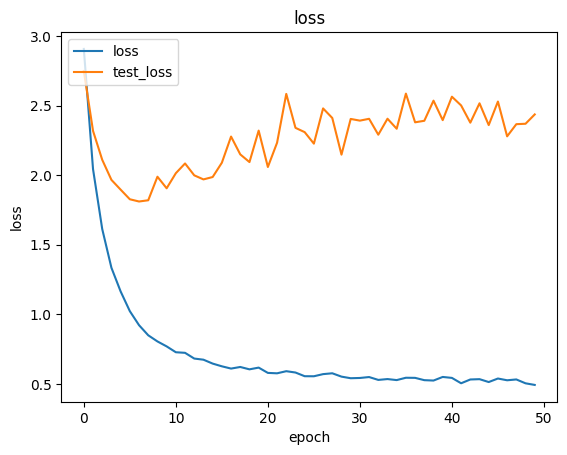| 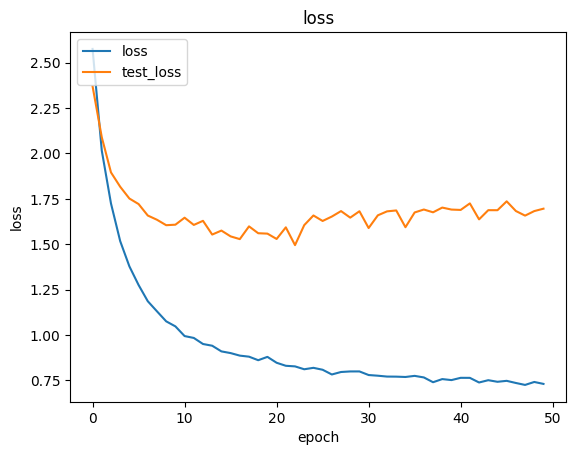|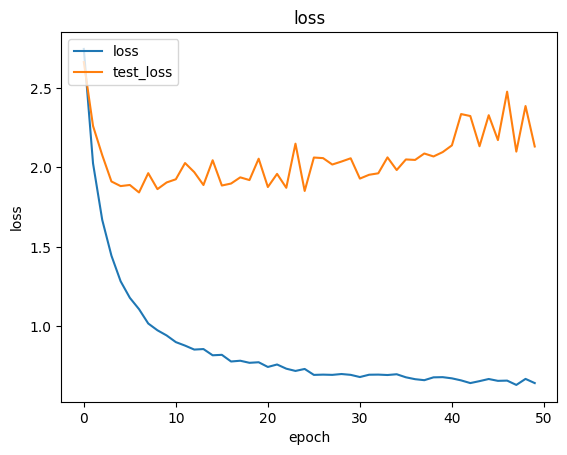 | 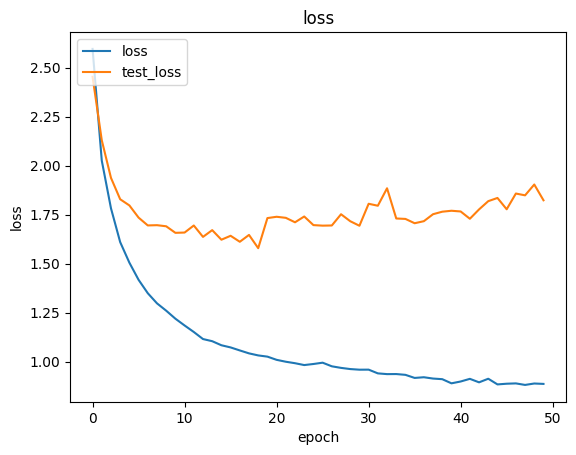|
|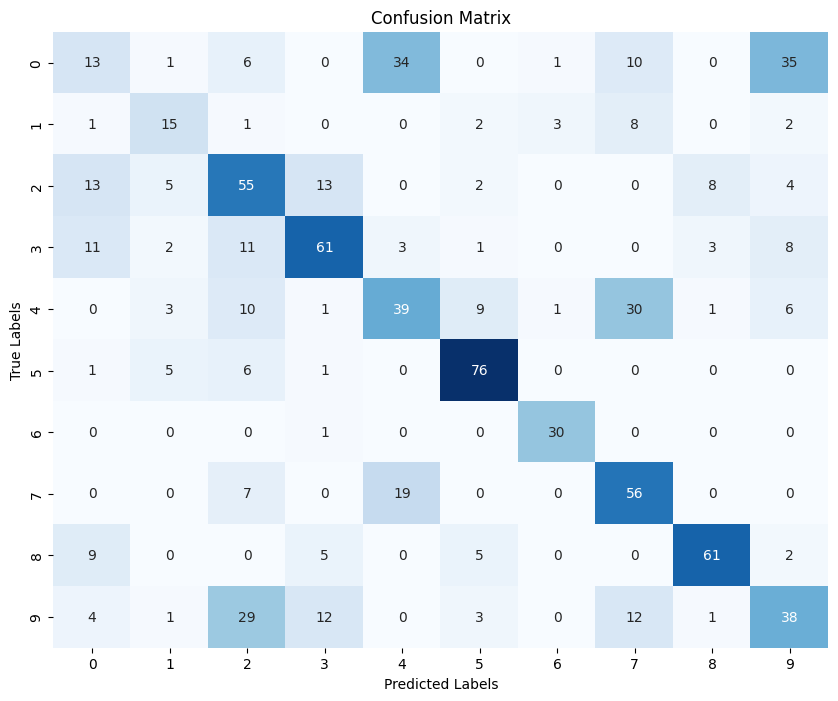|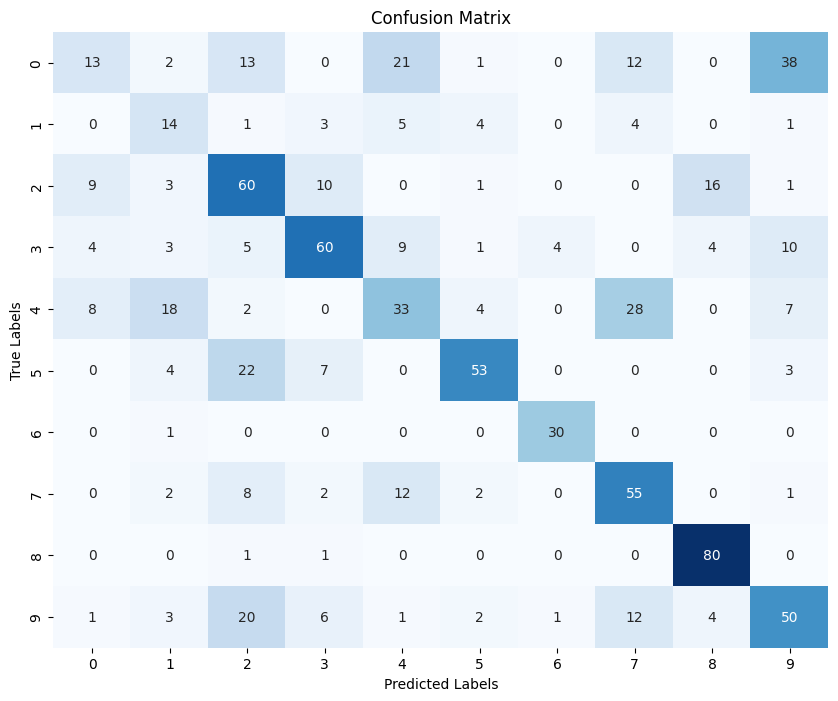|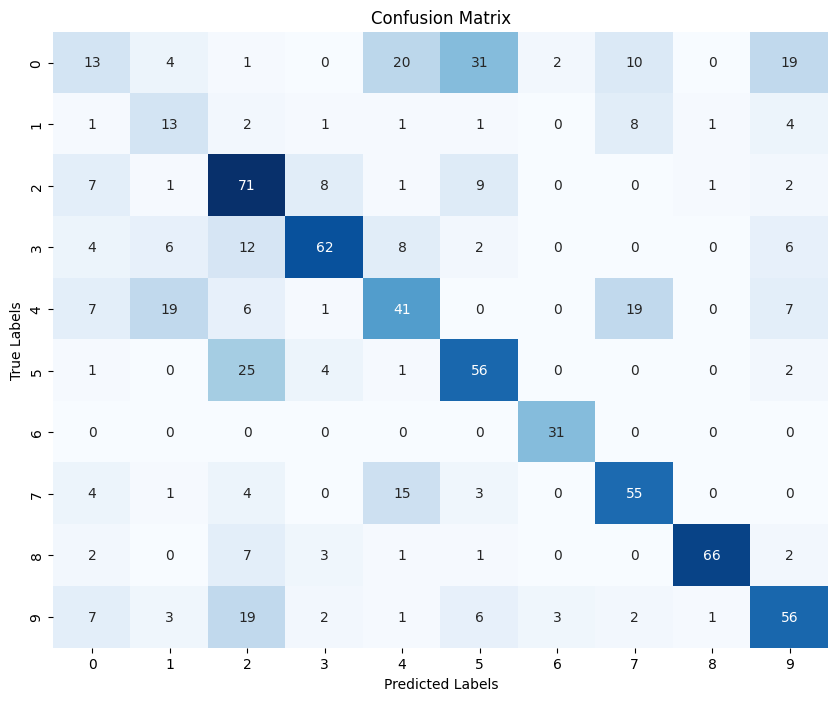 | 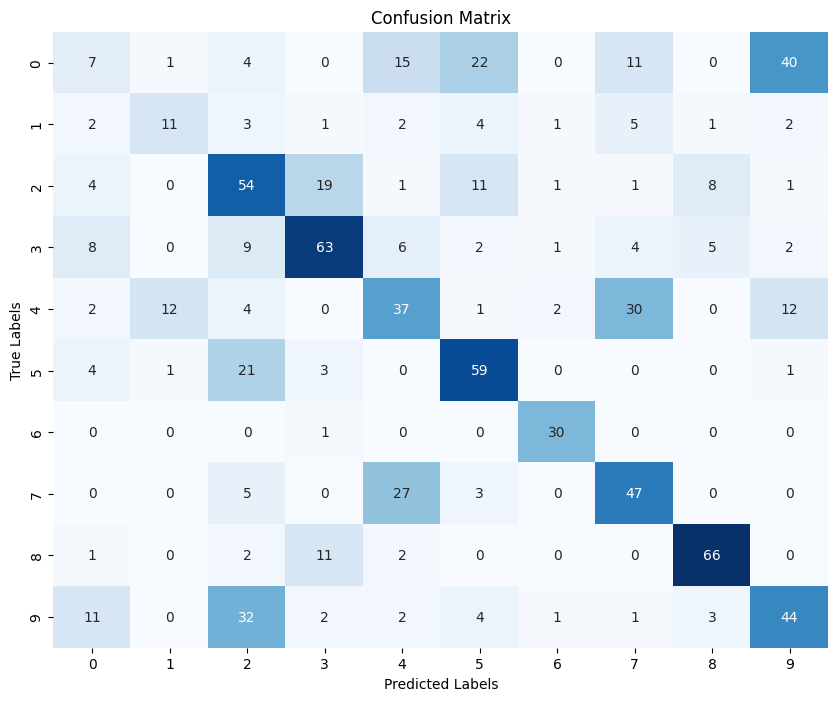|
|loss: 2.3054 - accuracy: 0.5748|loss: 2.1027 - accuracy: 0.5613|loss: 2.2650  - accuracy: 0.5674|loss: 1.7436 - accuracy: 0.5331|


Uma vez que nenhum dos resultados está de acordo com o desejado, decidimos implementar alterações nas funções que criam os modelos MLP.

Neste sentido, experimentamos adicionar mais uma *hidden layer* a cada modelo de MLP. 
Para o modelo mais simples, a *hidden layer* acrescentada conta com 8 neurónios. Já no modelo mais complexo, acrescentamos uma camada com 256 neurónios e mantivemos a função de ativação ("relu") e o valor da penalização (0.01).

Assim, redefinimos as duas estruturas do MLP da seguinte forma:

In [ ]:
# Definir a MLP
def create_mlp(input_shape, num_classes):
    model = models.Sequential()

    #Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))

    #Hidden Layers
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization())  

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  
    model.add(BatchNormalization())  

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization()) 

    #Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
def simpler_mlp(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=input_shape))

    model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(layers.Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Resultados obtidos: Experiência_2 #

O efeito que estas alterações têm no desempenho dos modelos, pode ser visualizado nos seguintes gráficos:


|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|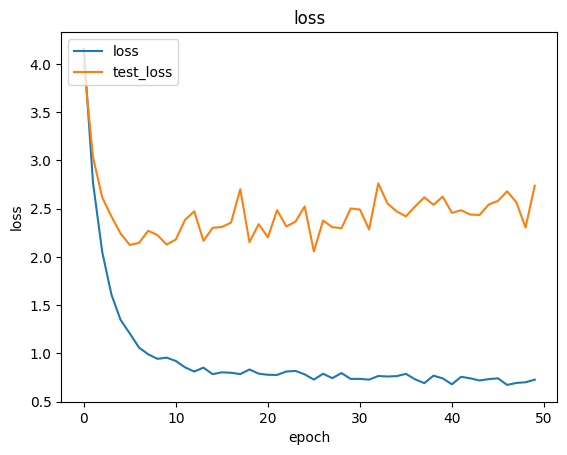| 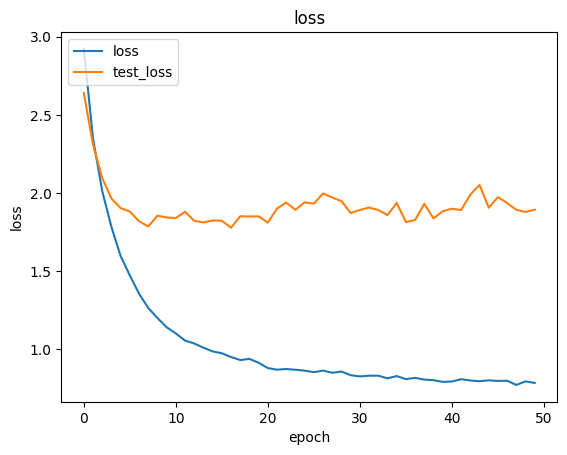|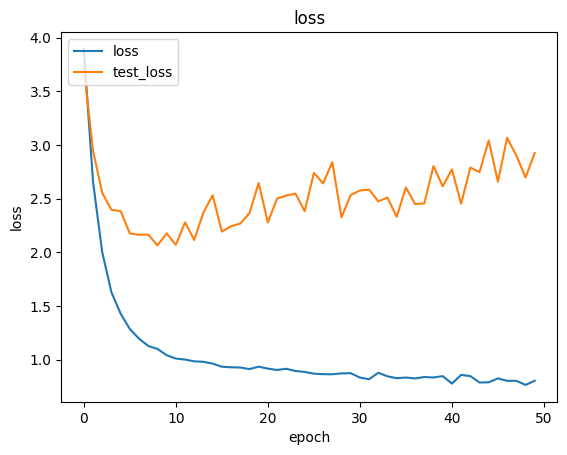 |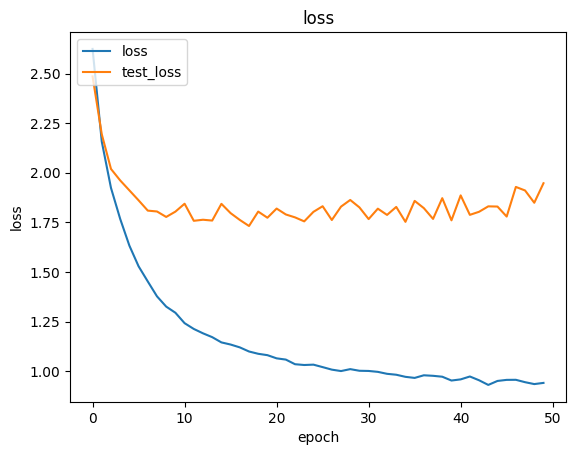|
|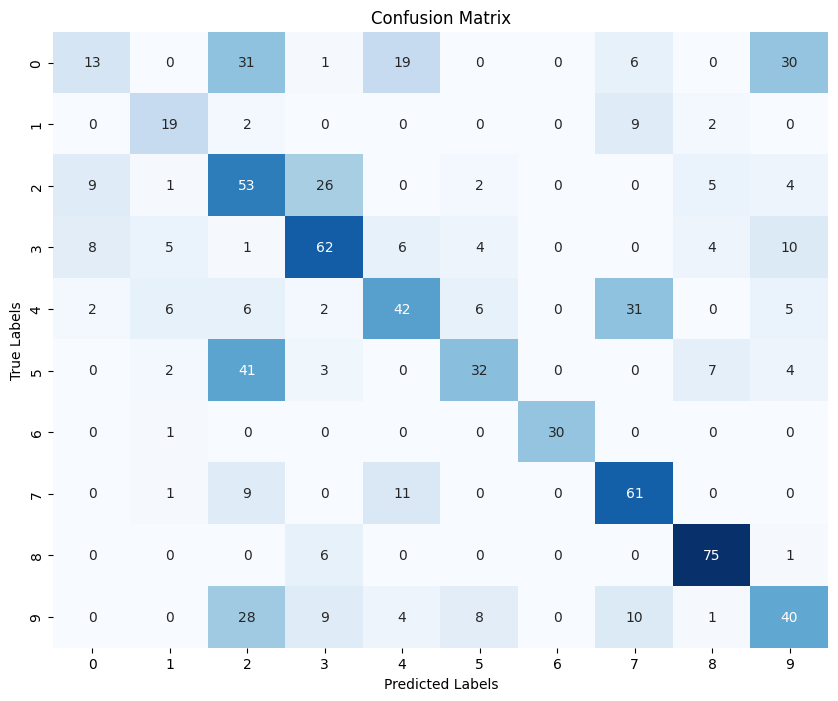|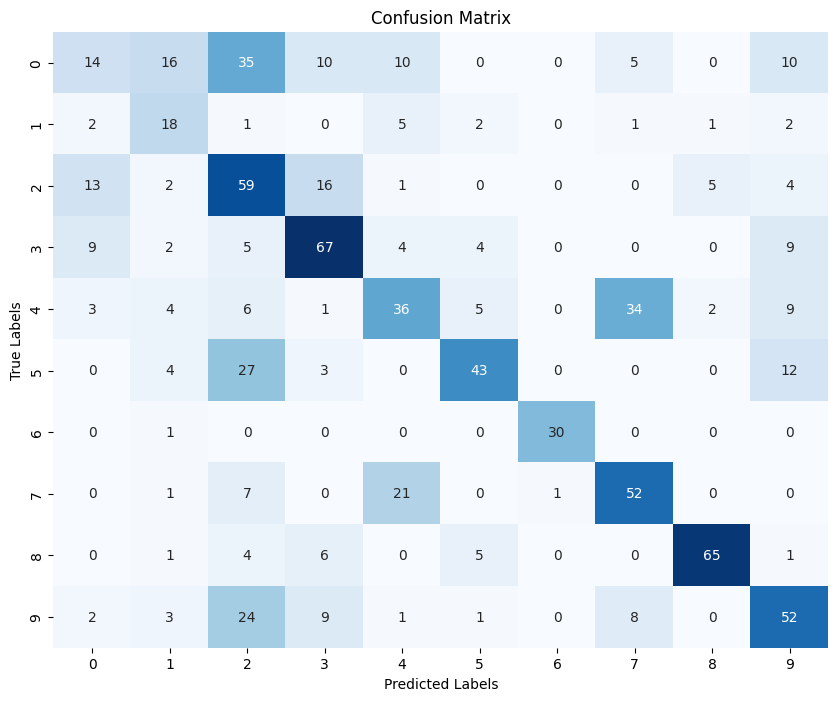|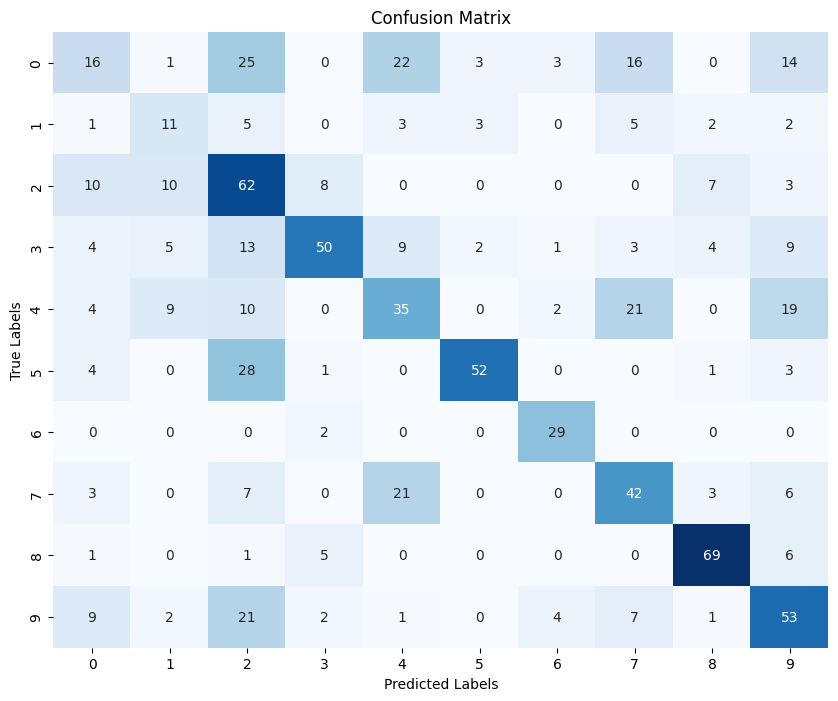 |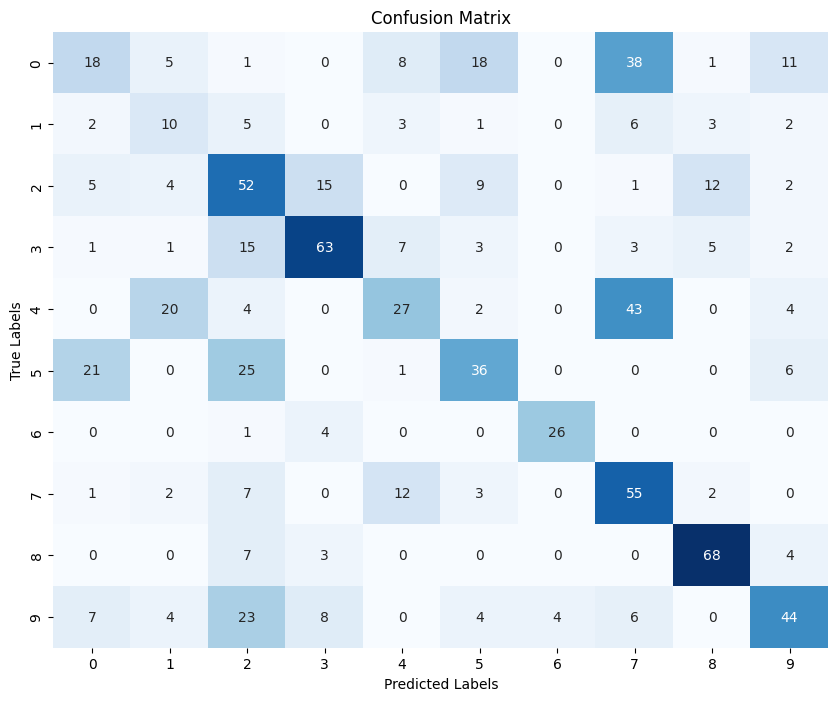 |
|loss: 2.4383 - accuracy: 0.5588|loss: 1.9232 - accuracy: 0.5478|loss: 2.6389 - accuracy: 0.5319|loss: 1.9117 - accuracy: 0.5098|

Ao analisarmos estes resultados, verificámos que não existiram melhorias significativas com a adição da nova camada. 

Neste sentido, decidimos adotar uma nova abordagem focada no aumento da diversidade dos dados do conjunto de treino. 

Para isso, implementamos **Data Augmentation**, tendo sido definidas as seguintes funções: 

- *time-shift*: Realiza um deslocamento temporal aleatório no sinal de entrada, com o objetivo de introduzir variações temporais nos dados das amostras.

- *amplitude-scaling*: Aplica uma escala aleatória à amplitude do sinal, multiplicando-o por um fator aleatório dentro de um intervalo definido. Esta função foi definida com o intuito de simular variações na intensidade do som.

Foi ainda necessário redefinir a função de processamento de dados, a qual se passou a chamar *preprocess_dataset_aug*. 

Nesta função foi introduzido o parâmetro *augment*, que ao estar ativado, aplica as técnicas de Data Augmentation exclusivamente ao conjunto de treino.

Nesta experiência decidimos também aumentar o valor da penalização para 0.1.

# Resultados obtidos: Experiência_3 #

Os resutados obtidos são os seguintes:




|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|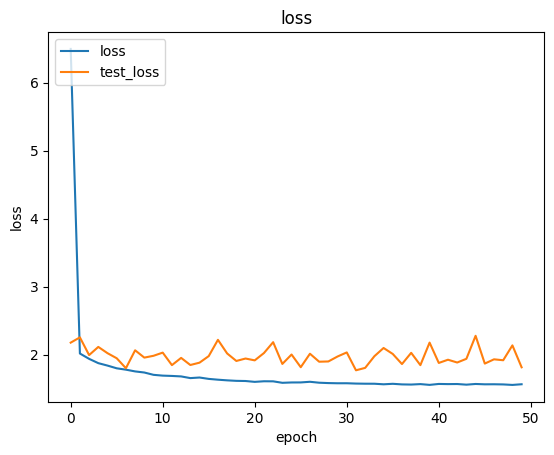|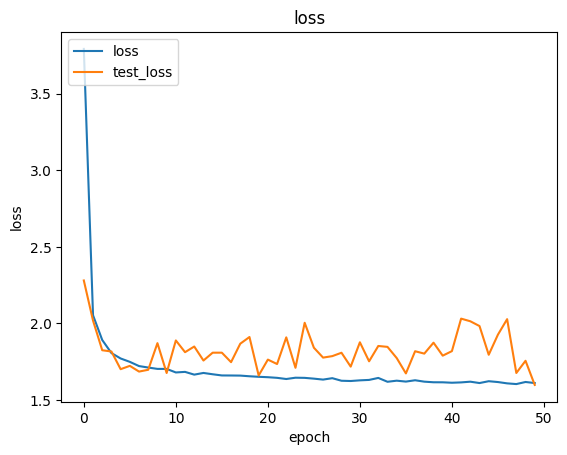|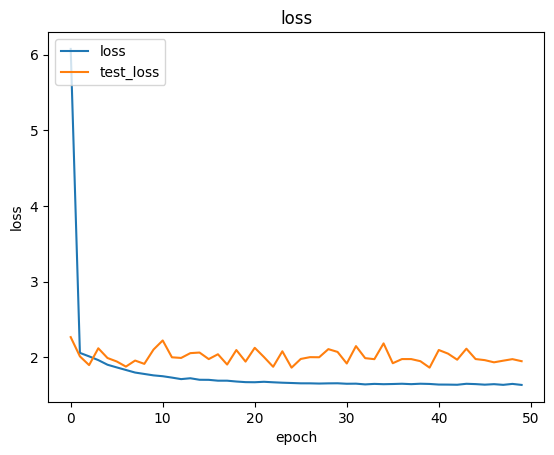|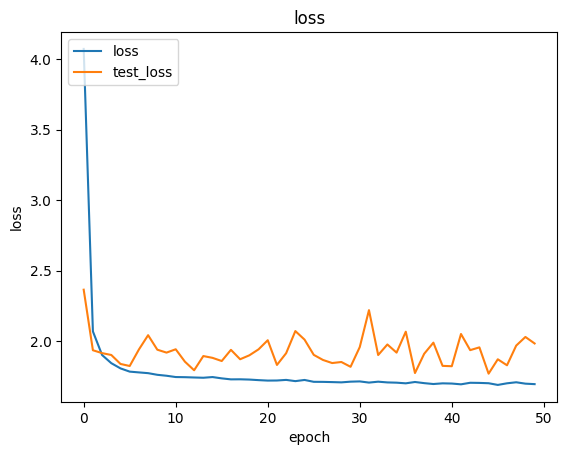|
|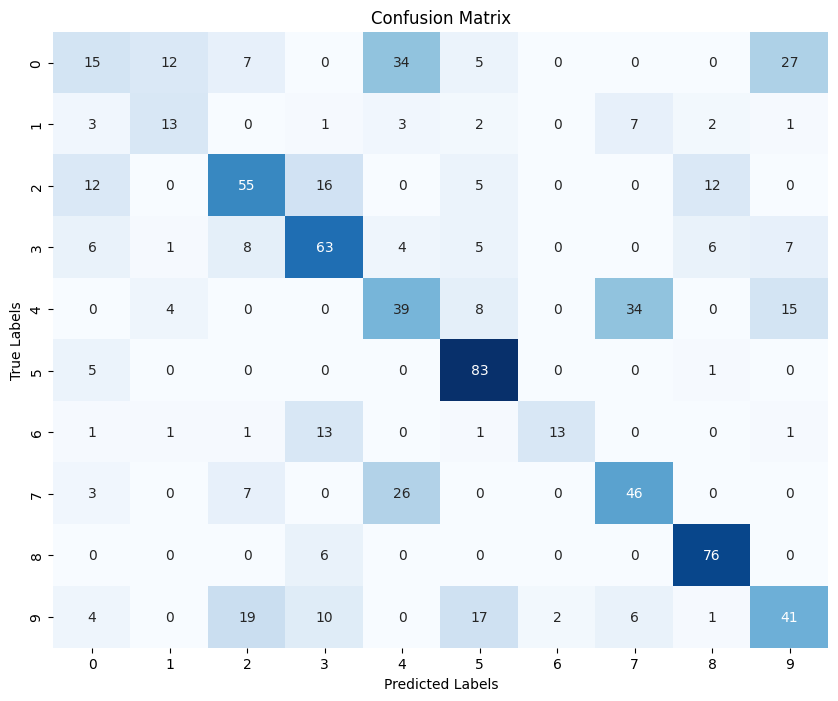|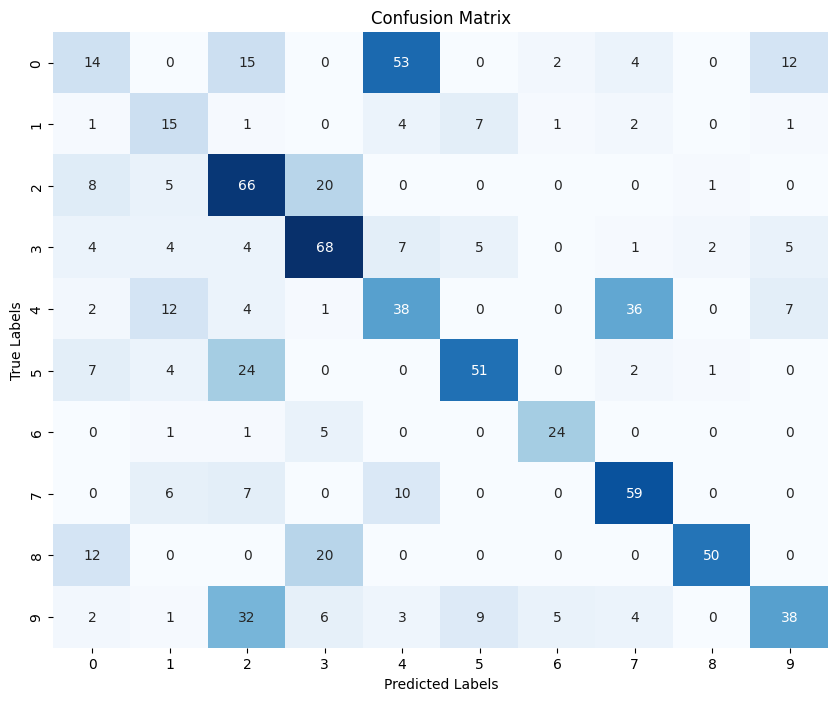|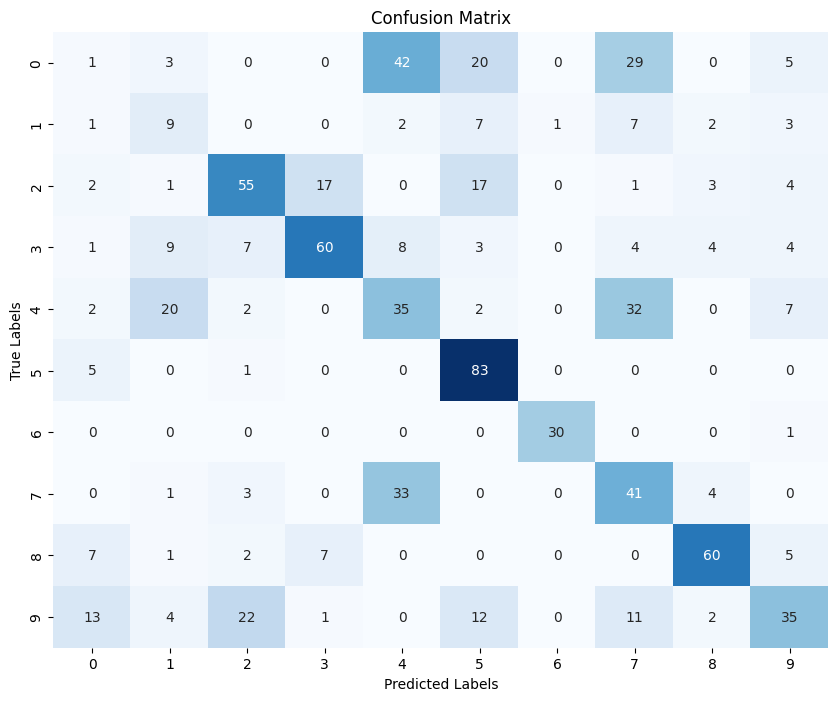|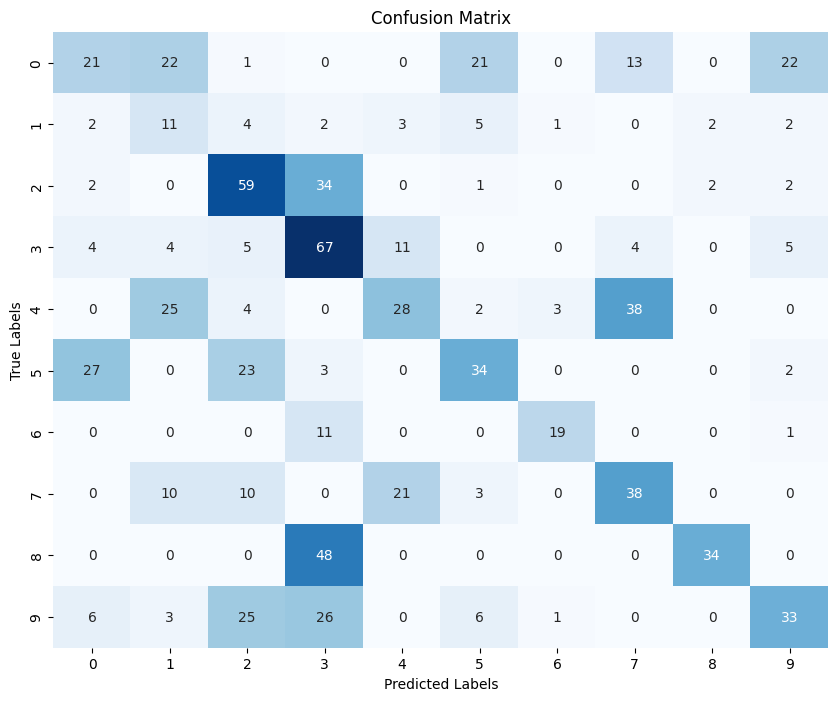|
|loss: 1.7653 - accuracy: 0.5441|loss: 1.6447 - accuracy: 0.5184|loss: 1.7128 - accuracy: 0.5012|loss: 1.7672 - accuracy: 0.4216|


Ao compararmos os resultados da experiência_3 com os da experiência_2, verificamos uma melhoria bastante significativa, principalmente com uma diminuição do valor da loss. Assim, decidimos manter o **Data Augmentation** e testar novas alterações, nomeadamente:

- redução do *max_shift* de 20 para 10;
- redução do *scale_min* de 0.7 para 0.5;
- redução do *scale_max* de 1.3 para 1.0.

Deste modo, as funções *time_sift*, *amplitude_scaling* e *preprocess_dataset_aug* são as apresentadas seguidamente:

In [ ]:
# Define funções de data augmentation para MLP

def time_shift(sample, max_shift=10):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(sample, shift, axis=0)

def amplitude_scaling(sample, scale_min=0.5, scale_max=1):
    scale = np.random.uniform(scale_min, scale_max)
    return sample * scale

def preprocess_dataset_aug(dataset_path, train_folds, test_folds, val_folds, num_classes=10, augment=True):

    # Carregar o dataset
    with open(dataset_path, 'rb') as file:
        dataset_mlp = pickle.load(file)

    # Converter para array numpy 
    dataset_mlp = np.array(dataset_mlp)
    print(f"Shape do dataset: {dataset_mlp.shape}")

    # Inicializar listas necessárias para o treino, teste e validação
    X_train, y_train = [], []
    X_test, y_test = [], []
    X_val, y_val = [], []

    # Preencher dados de treino
    for fold_idx in train_folds:
        data, labels = dataset_mlp[fold_idx]
        for sample, label in zip(data, labels):
            X_train.append(sample) 
            y_train.append(label)

            if augment:
                # Aplicar time_shift
                augmented_sample = time_shift(sample)
                X_train.append(augmented_sample)
                y_train.append(label)

                # Aplicar amplitude_scaling
                augmented_sample = amplitude_scaling(sample)
                X_train.append(augmented_sample)
                y_train.append(label)

    # Preencher dados de teste
    for fold_idx in test_folds:
        data, labels = dataset_mlp[fold_idx]
        X_test.extend(data)
        y_test.extend(labels)

    # Preencher dados de validação
    for fold_idx in val_folds:
        data, labels = dataset_mlp[fold_idx]
        X_val.extend(data)
        y_val.extend(labels)

    # Converter para arrays numpy 
    X_train = np.array(X_train).astype(float)
    y_train = np.array(y_train)
    X_test = np.array(X_test).astype(float)
    y_test = np.array(y_test)
    X_val = np.array(X_val).astype(float)
    y_val = np.array(y_val)

    # Codificar as labels como inteiros
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    y_val = encoder.transform(y_val)

    # Criar mapeamento de classes
    class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    print("Mapeamento de classes:", class_mapping)

    # Normalizar as features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    print(f"Shape de X_train: {X_train.shape}")
    print(f"Shape de X_test: {X_test.shape}")
    print(f"Shape de X_val: {X_val.shape}")

    return X_train, y_train, X_test, y_test, X_val, y_val

Após estas alterações, observámos uma melhoria nos resultados obtidos. Com base nisso, decidimos dar continuidade às otimizações já realizadas, implementando novas alterações, nomeadamente o aumento do número de neurónios nas camadas do modelo. Consequentemente, resolvemos também reduzir o valor da penalização de   0.1 para 0.01.


# Resultados obtidos: Experiência_4 #

Assim, podemos observar os resultados nos seguintes gráficos:

|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|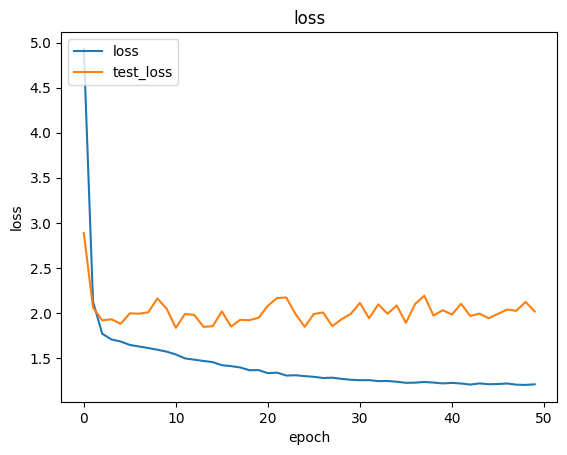|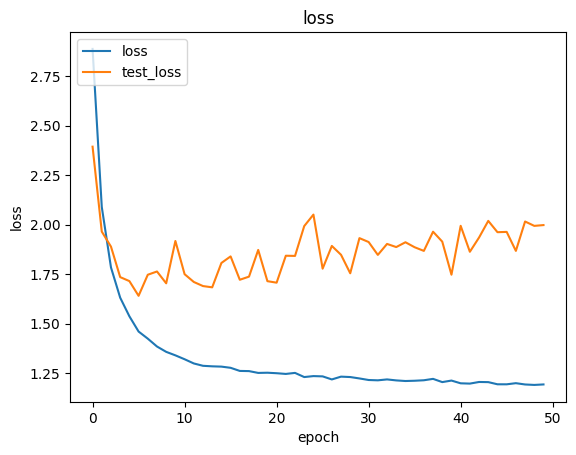|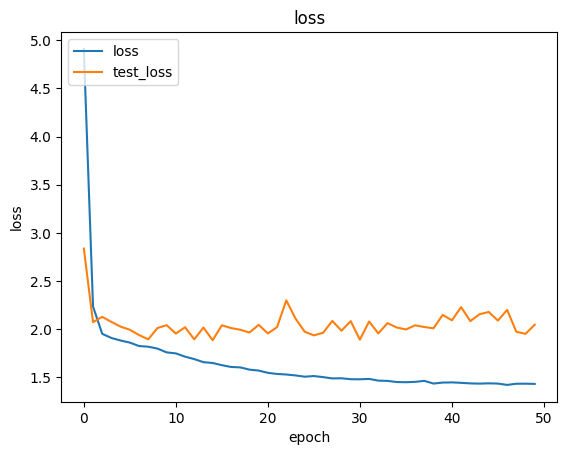|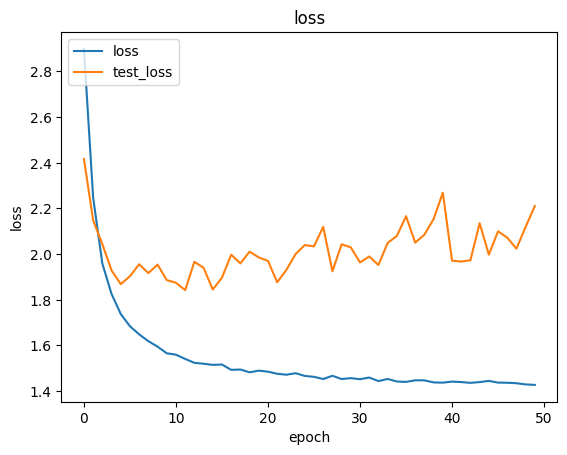|
|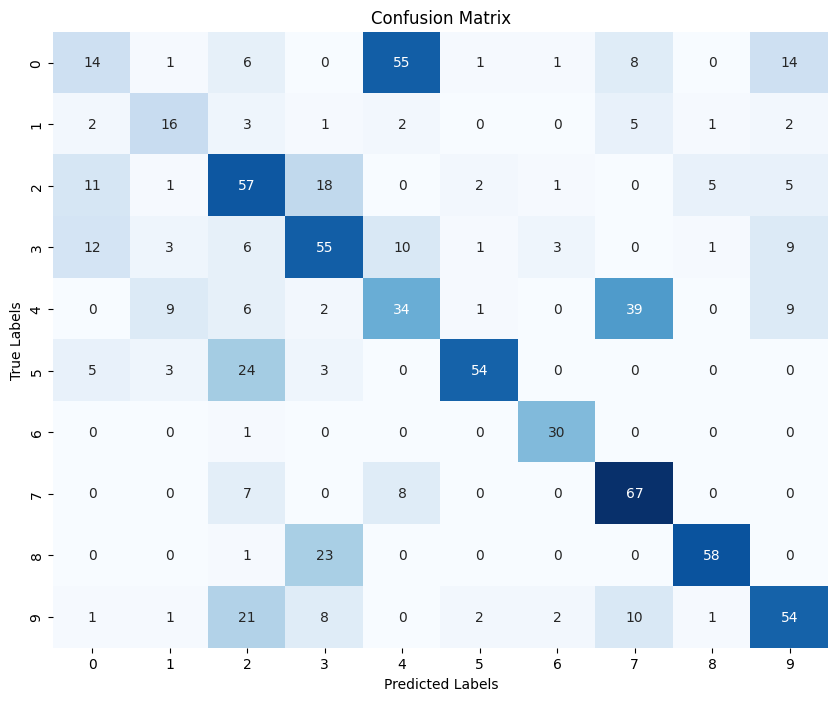|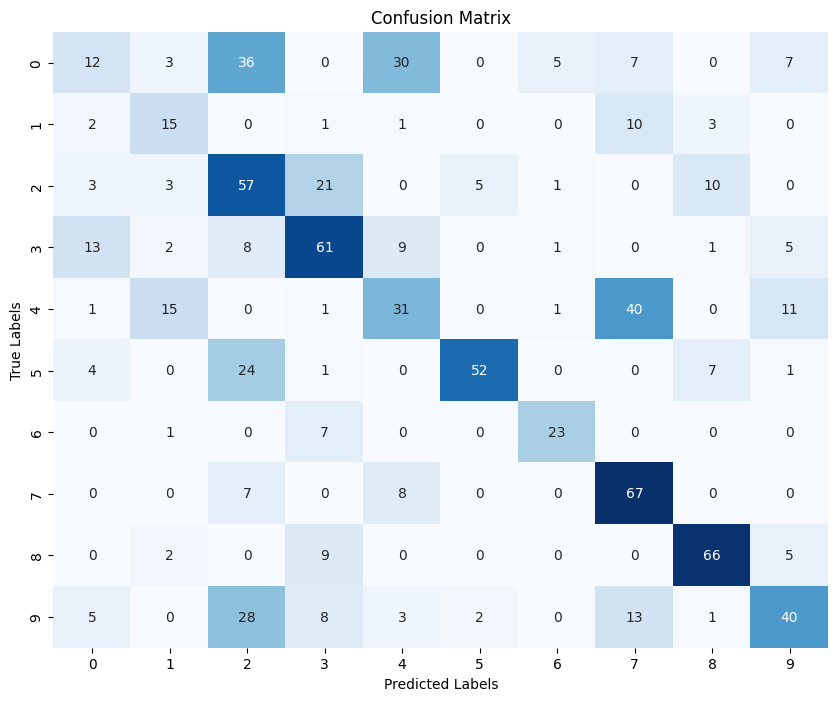|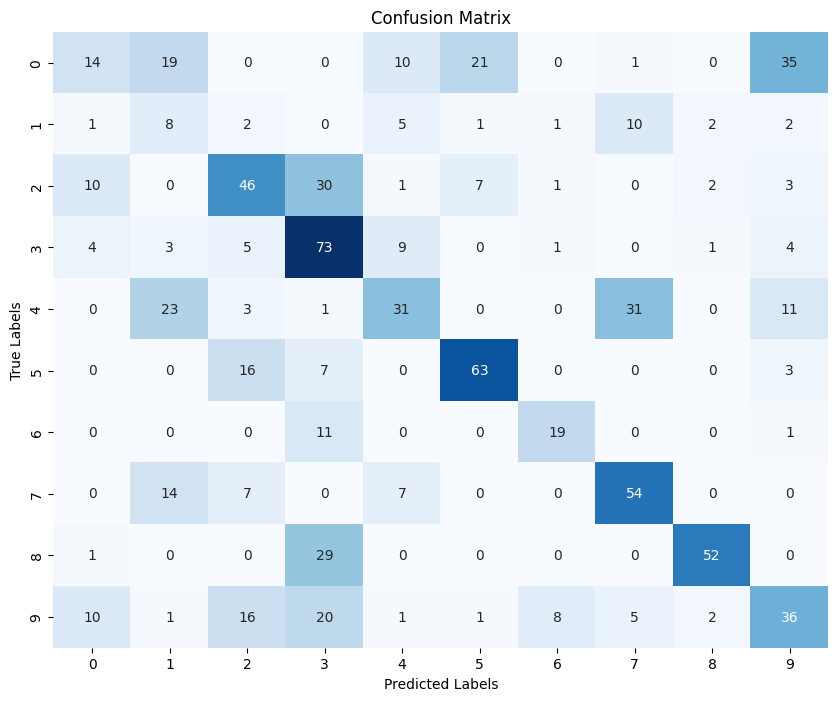|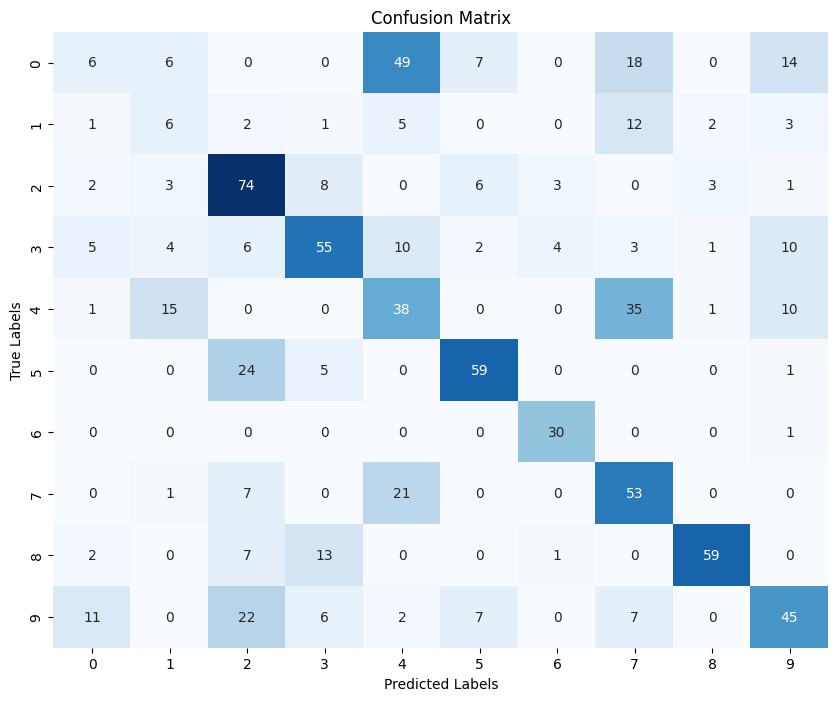|
|loss: 1.9778  - accuracy: 0.5380|loss: 2.0586 - accuracy: 0.5196|loss: 1.7818 - accuracy: 0.4853|loss: 1.8109 - accuracy: 0.5208|

A partir da análise destes resultados, podemos verificar que, de forma geral, o desempenho do modelo diminuiu.

No entanto, uma vez que não conseguimos associar essa diminuição de desempenho ao aumento da complexidade do modelo, decidimos manter o número de neurónios e as restantes alterações efetuadas anteriormente.

Assim, procuramos outras alternativas, definindo uma combinação de **Batch Normalization** e **Dropout**, com uma taxa de 0.3, para testar o impacto que teriam no modelo. É de notar que testamos vários valores para o **Dropout** entre 0.1 e 0.5.

Numa primeira execução, verificamos melhorias significativas nas métricas calculadas, cujos resultados são apresentados na experiência 5.

# Resultados obtidos: Experiência_5 #



|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|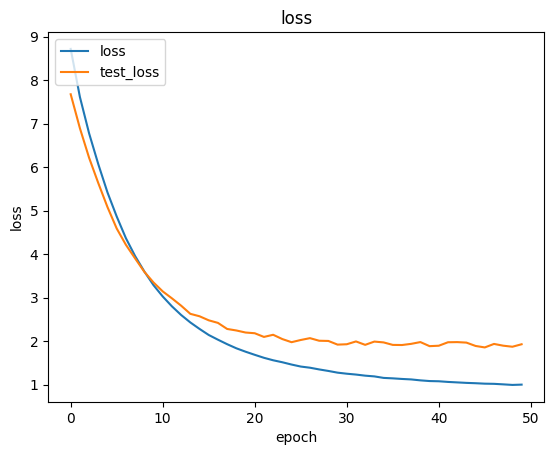|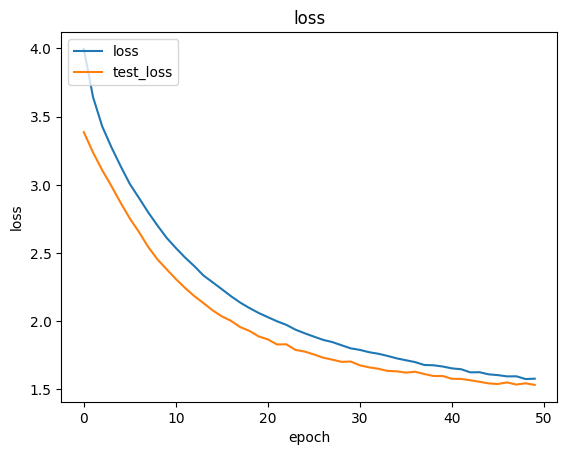|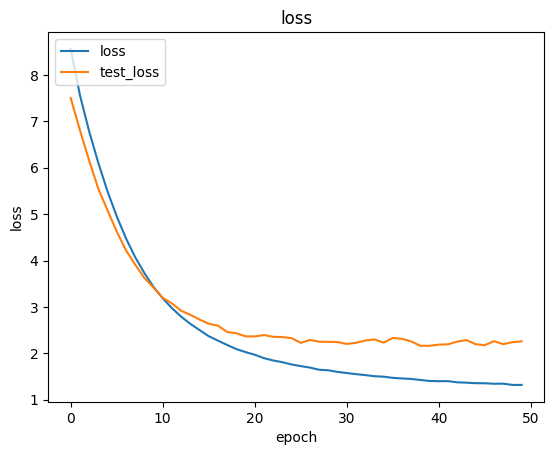|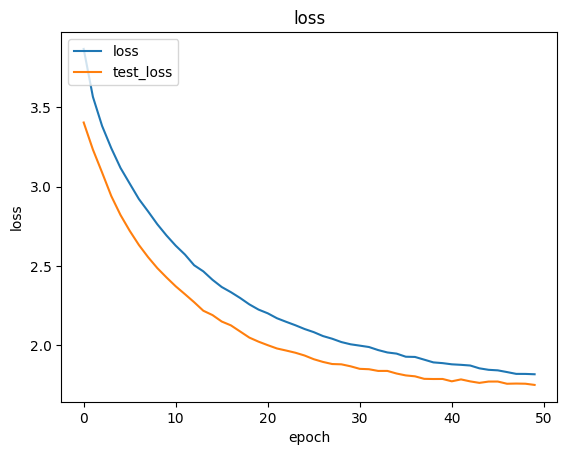|
|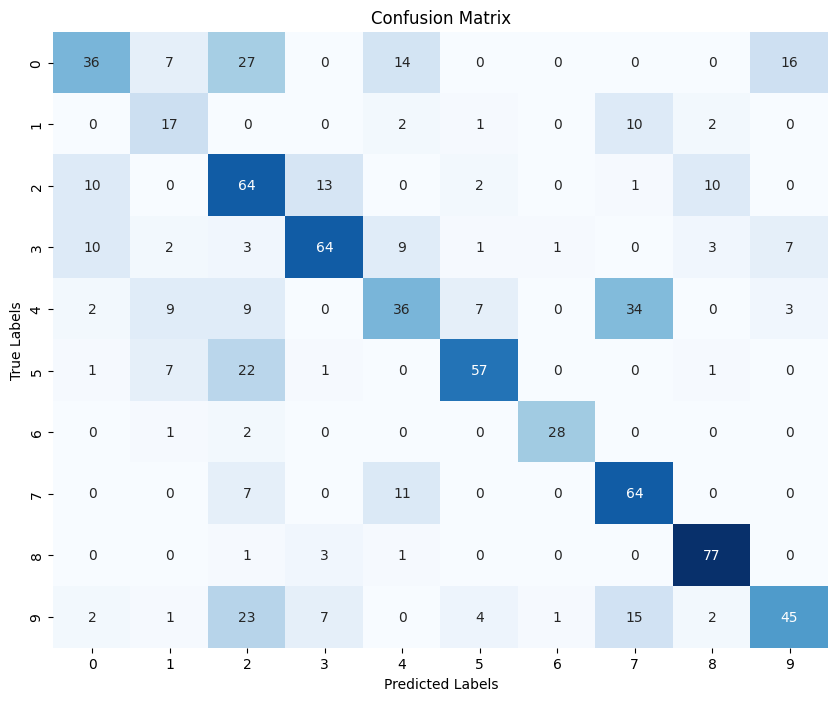|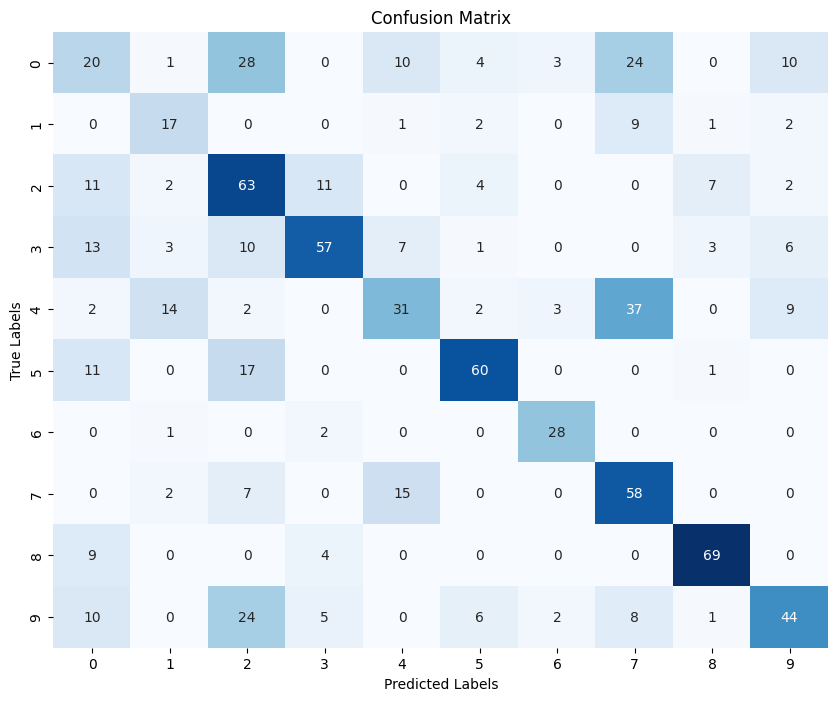|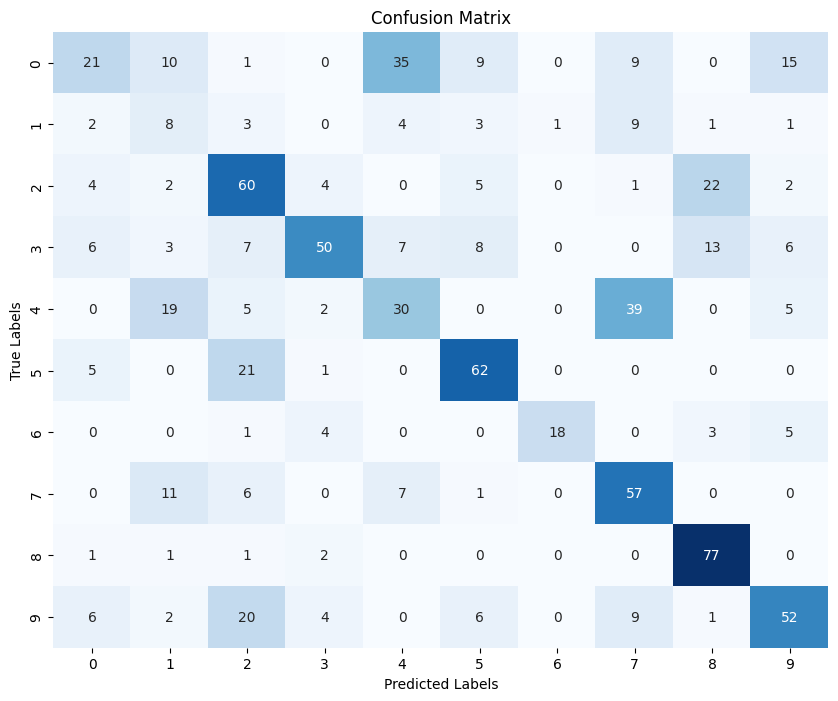|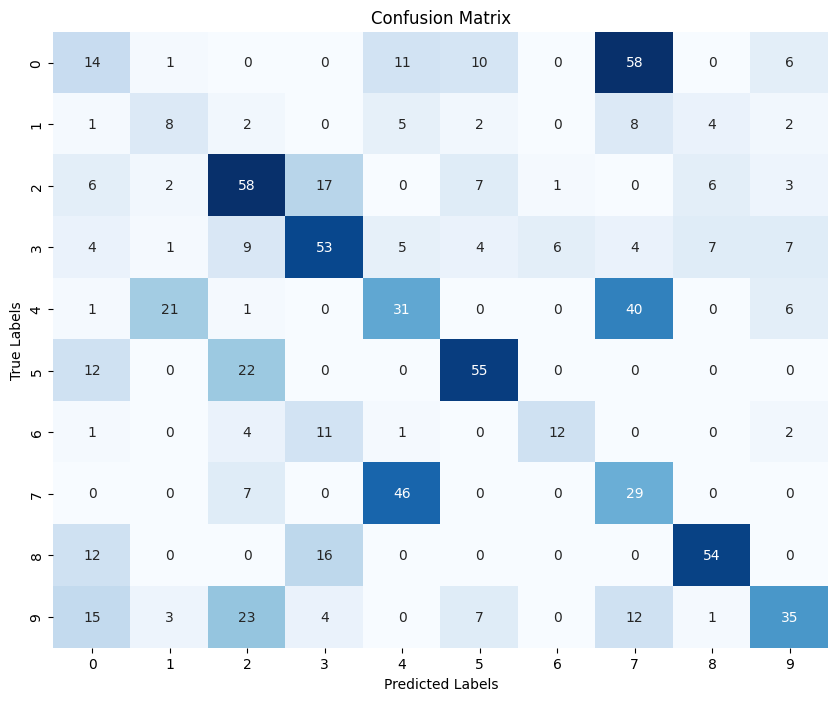|
|loss: 1.8415 - accuracy: 0.5980|loss: 1.4628 - accuracy: 0.5478|loss: 1.8673 - accuracy: 0.5331|loss: 1.6694 - accuracy: 0.4277|

Com a análise dos gráficos, verificamos uma redução consistente da loss ao longo das epochs, com curvas de treino e teste mais próximas, indicando uma redução do overfitting. Além disso, a loss no conjunto de teste é mais estável e apresenta valores finais mais baixos.

Percebemos também que houve uma melhoria muito significativa relativamente à accuracy, sobretudo no modelo de 13 coeficientes.

Consideramos por isso, que até então esta é a melhor configuração do modelo MLP. 

Alguns dos parâmetros cuja influência no modelo ainda não tinhamos testado eram os otimizadores e as funções de ativação. Por isso, estas foram as alterações que testamos posteriormente, no sentido de tentar melhorar o modelo.

Ajustámos o valor do *learning_rate* do *optimizer*, na função *compile_mlp*, para 0.0001. Esta alteração não apresentou melhorias significativas nos resultados da experiência 5. 

Seguidamente, testámos a utilização do otimizador **RMSprop** como alternativa ao **Adam**, cujos resultados estão descritos na experiência 6.

# Resultados obtidos: Experiência_6 #

|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|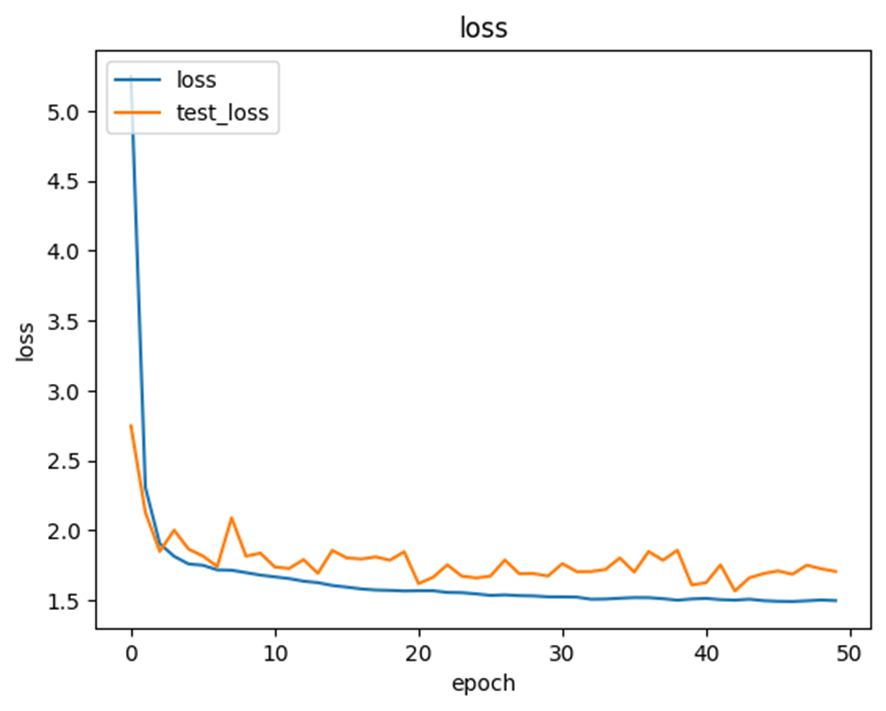|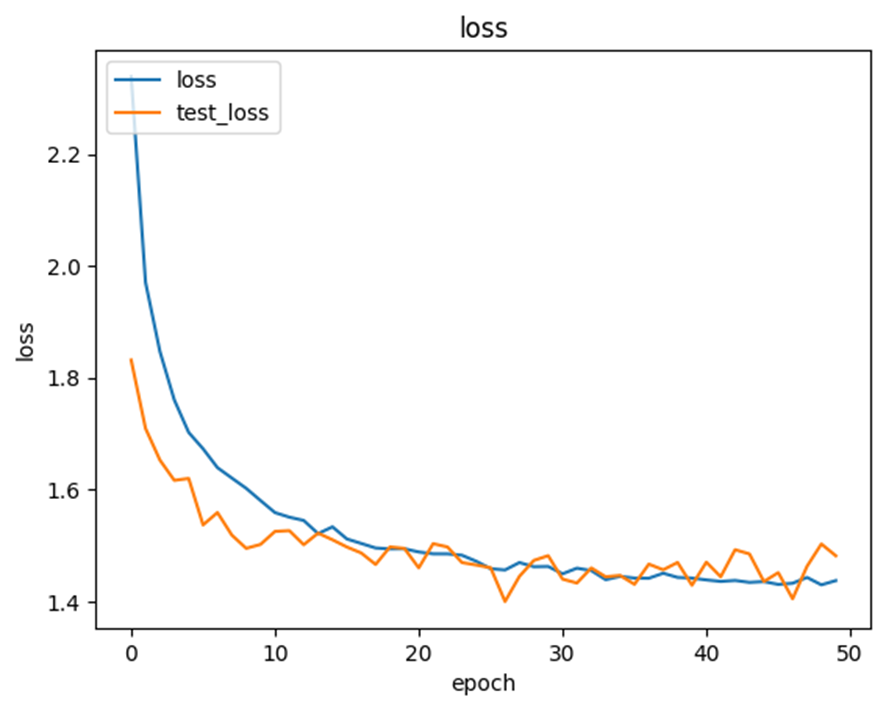|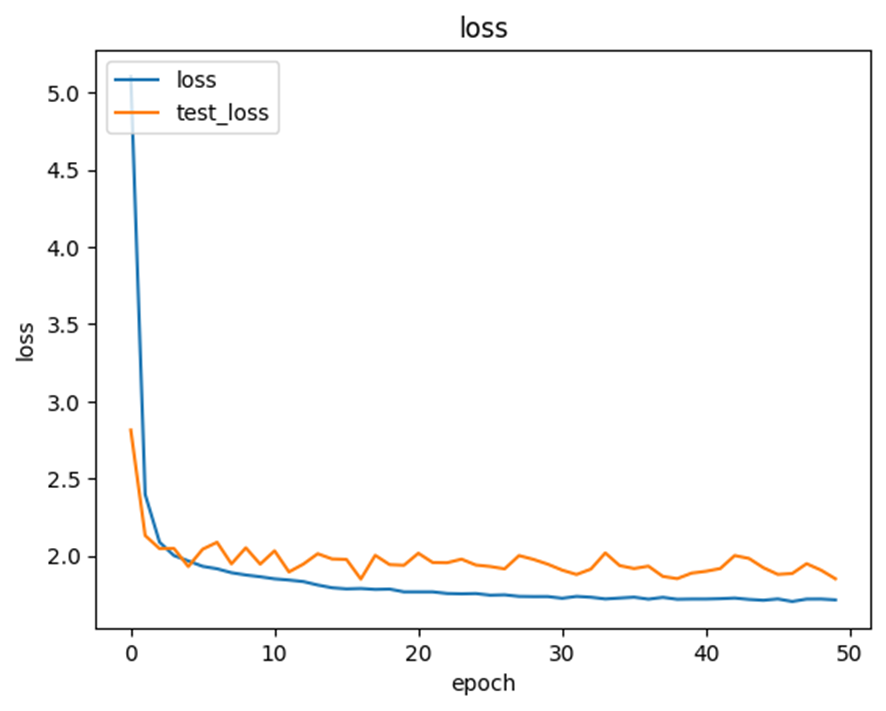|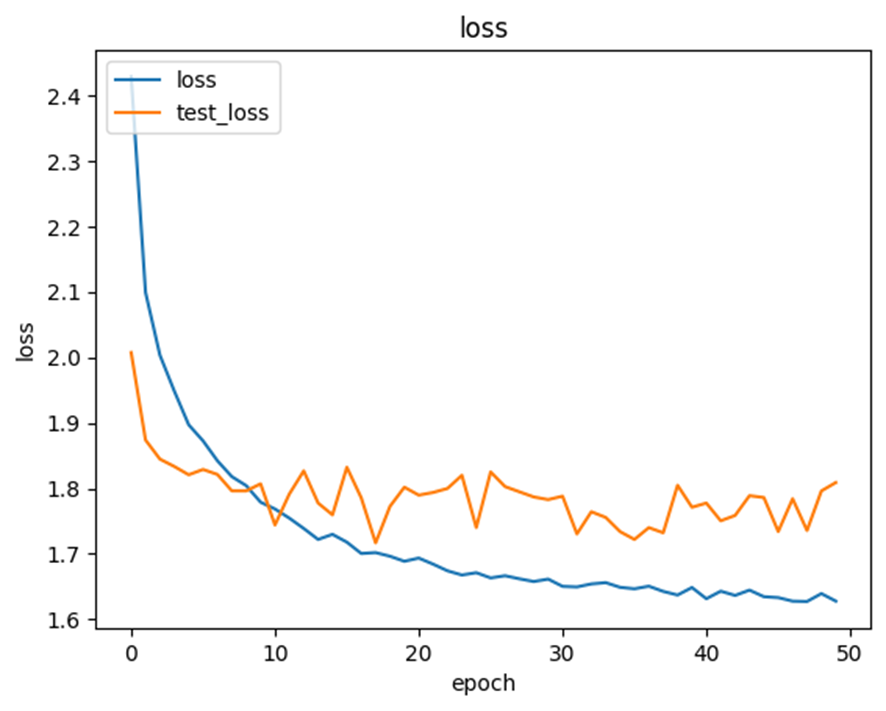|
|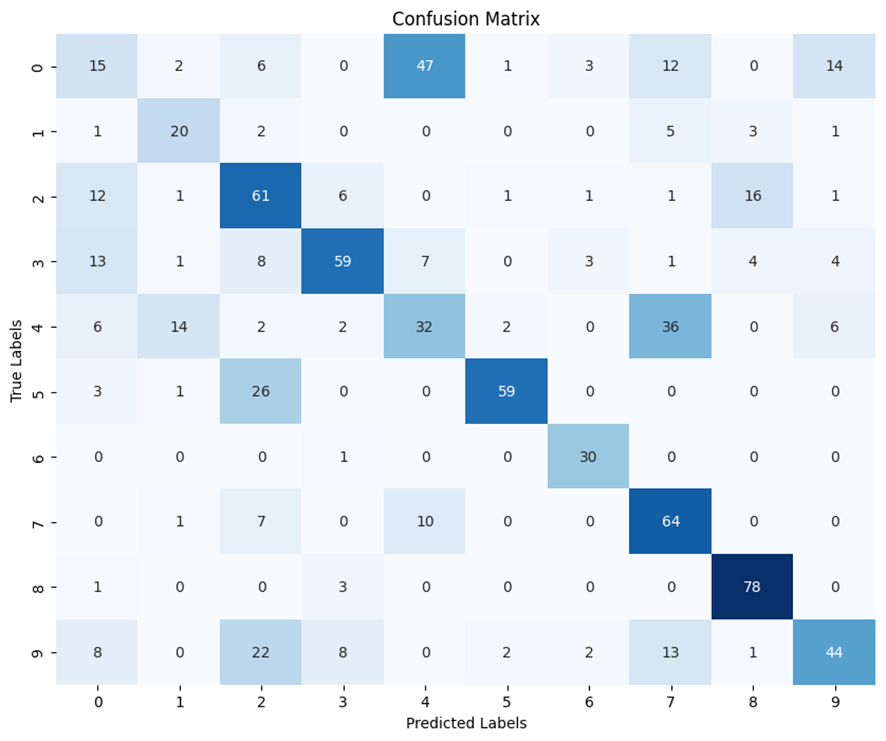|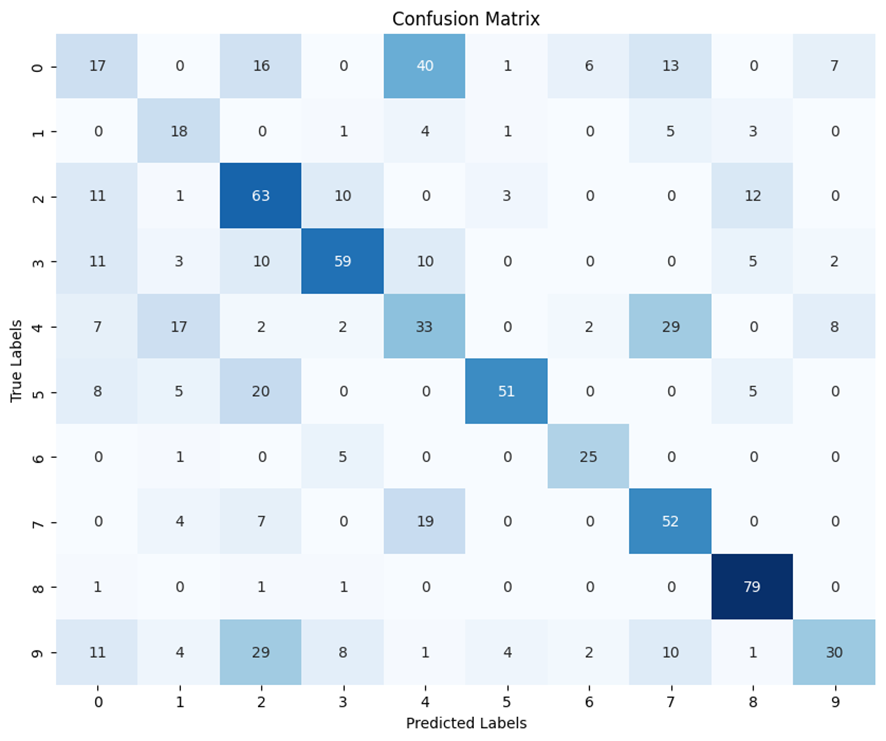|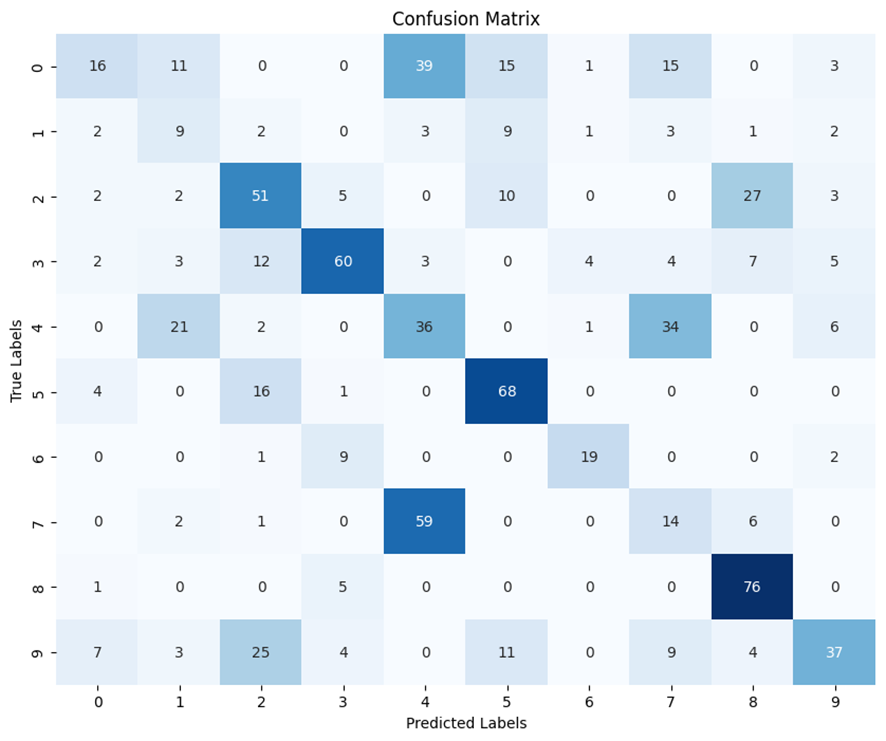|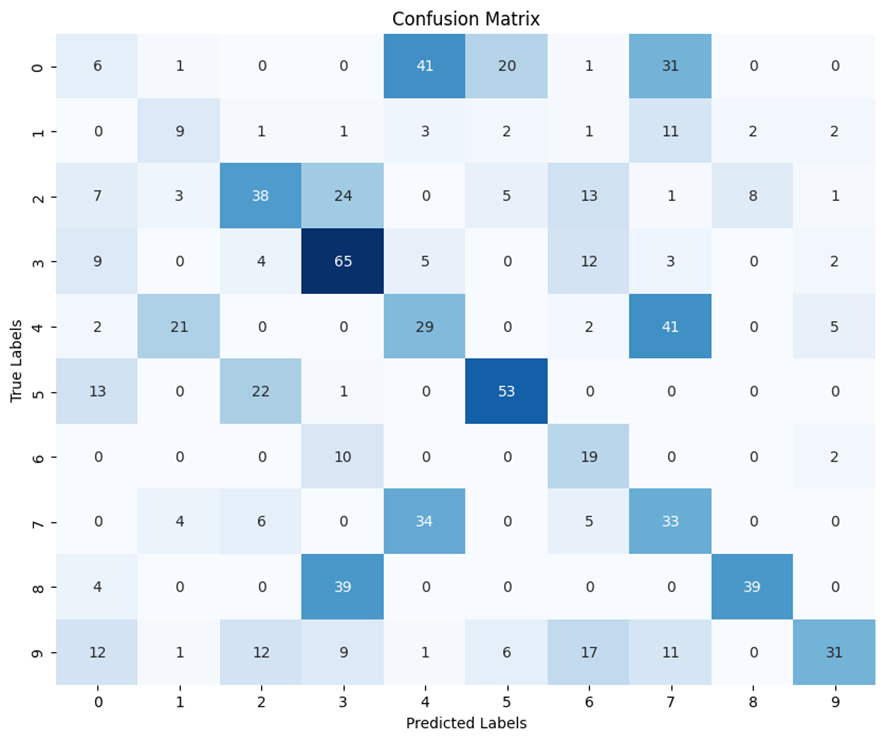|
|loss: 1.6006 - accuracy: 0.5662|loss: 1.4464 - accuracy: 0.5233|loss: 1.7056 - accuracy: 0.4730|loss: 1.7020 - accuracy: 0.3946|

Em relação à evolução da loss ao longo das *epochs*, esta mostrou-se menos consistente, com maior oscilação e picos evidentes nos gráficos apresentados anteriormente. Também em relação às métricas, os resultados mostraram-se piores. 

Por este motivo, optámos por continuar a utilizar o otimizador **Adam** nas experiências seguintes.

Embora a curva da loss já apresentasse convergência nos resultados anteriores, decidimos aumentar o número de epochs de 50 para 100. Como observamos uma melhoria no desempenho do modelo com esta alteração, optámos por manter o novo valor. 

Diminuímos, posteriormente, o número de neurónios de cada camada, de modo que as funções *create_mlp* e *simpler_mlp* ficaram:

In [ ]:
# Definir a MLP
def create_mlp(input_shape, num_classes):
    model = models.Sequential()

    #Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))

    #Hidden Layers
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization())  
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  
    model.add(BatchNormalization())  
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization())  
    model.add(layers.Dropout(0.3))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
def simpler_mlp(input_shape, num_classes):
    model = models.Sequential()

    #Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))

    #Hidden Layers
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.3))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Resultados obtidos: Experiência_7 #

Os resultados relativos a estas alterações são os apresentados seguidamente:

|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|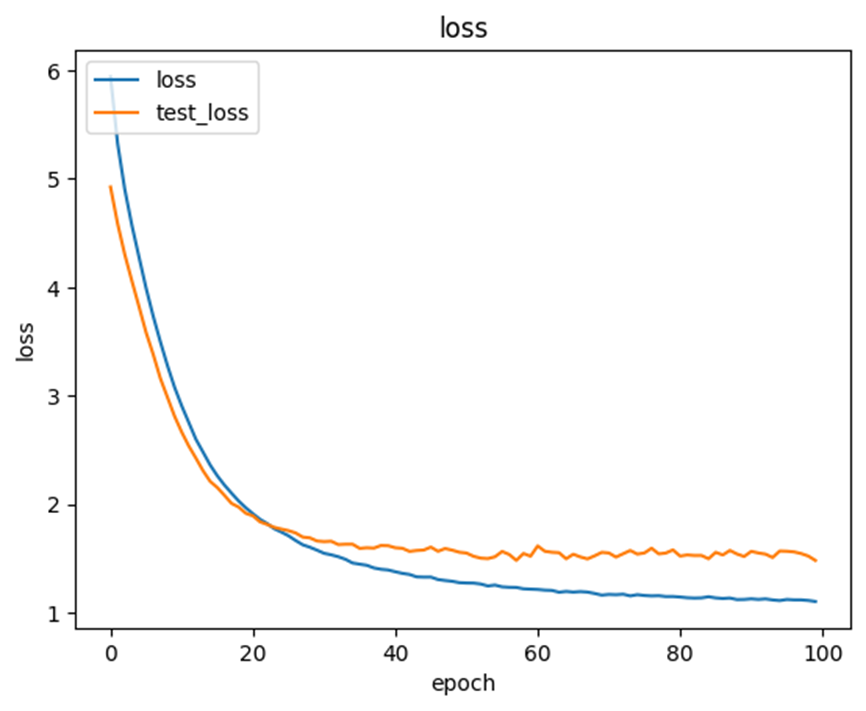|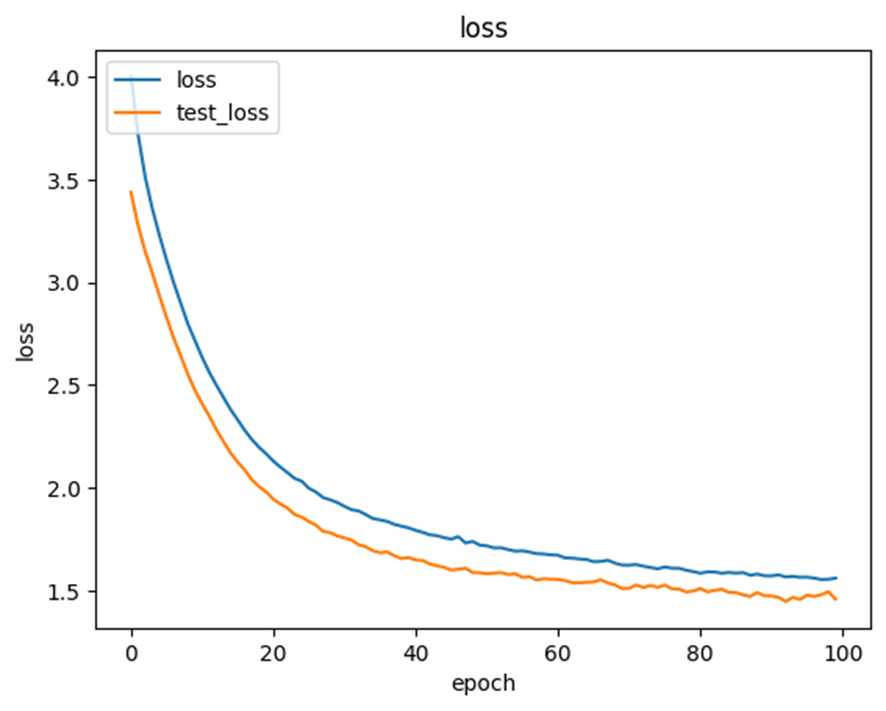|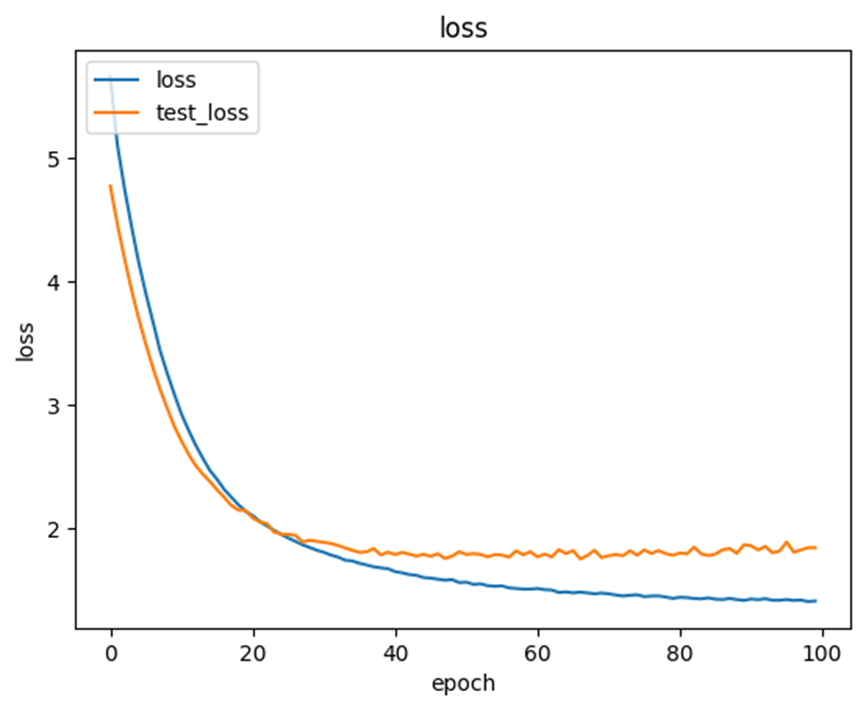|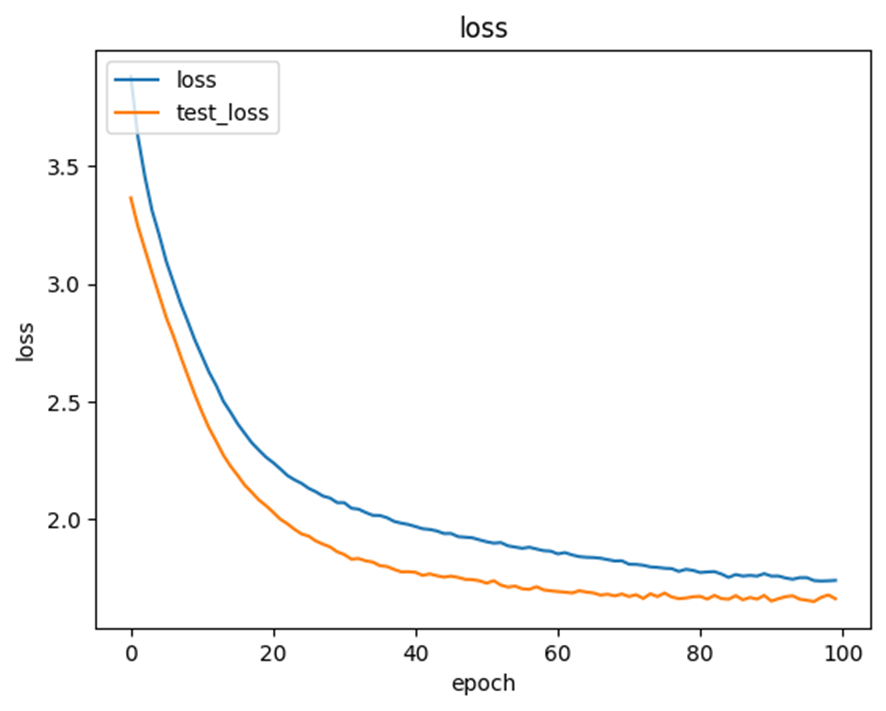|
|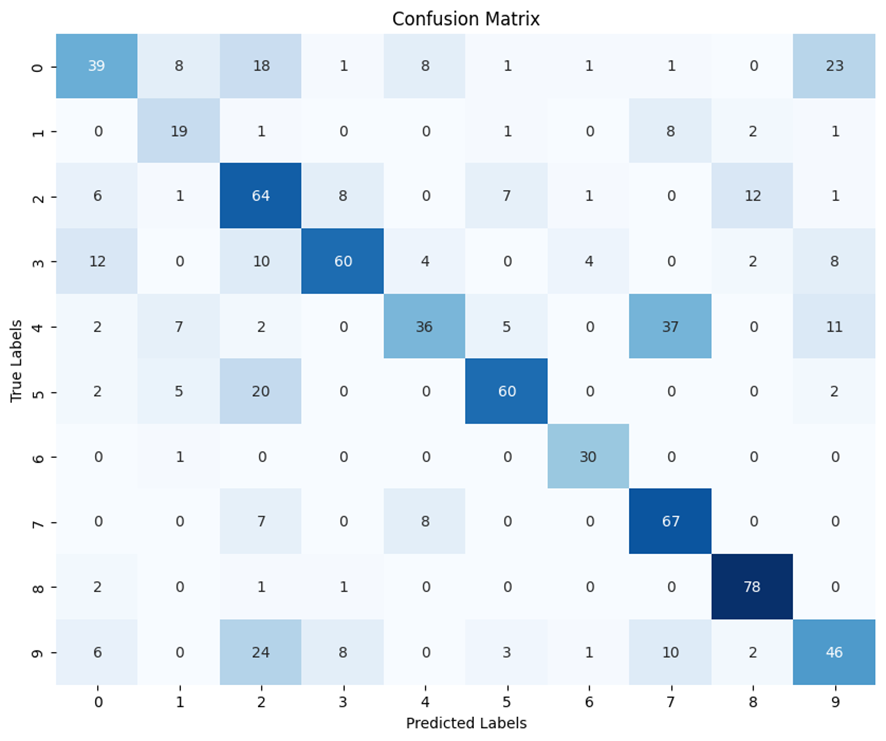|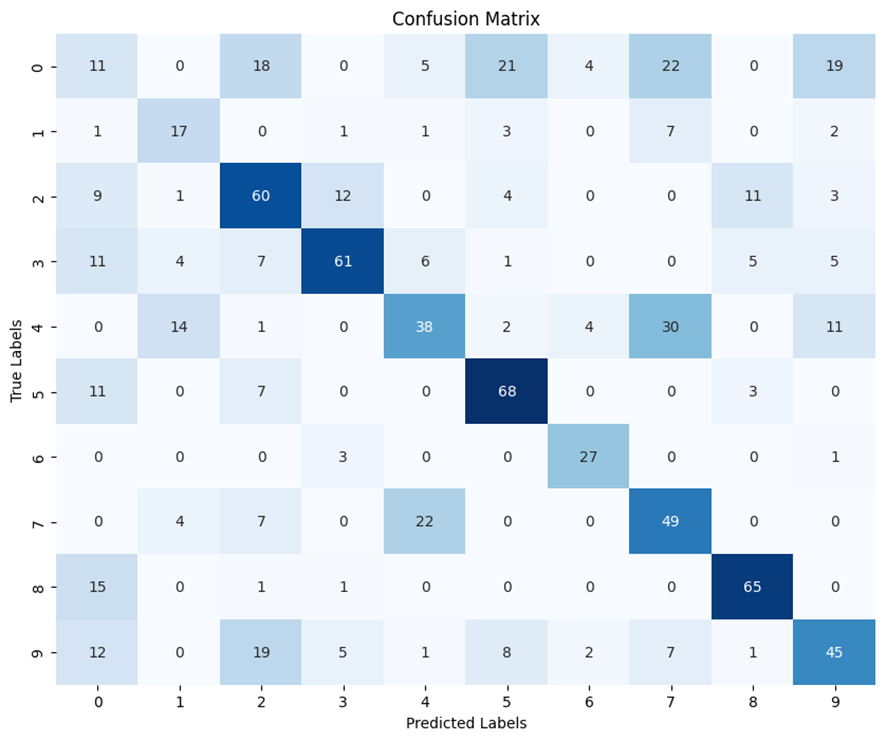|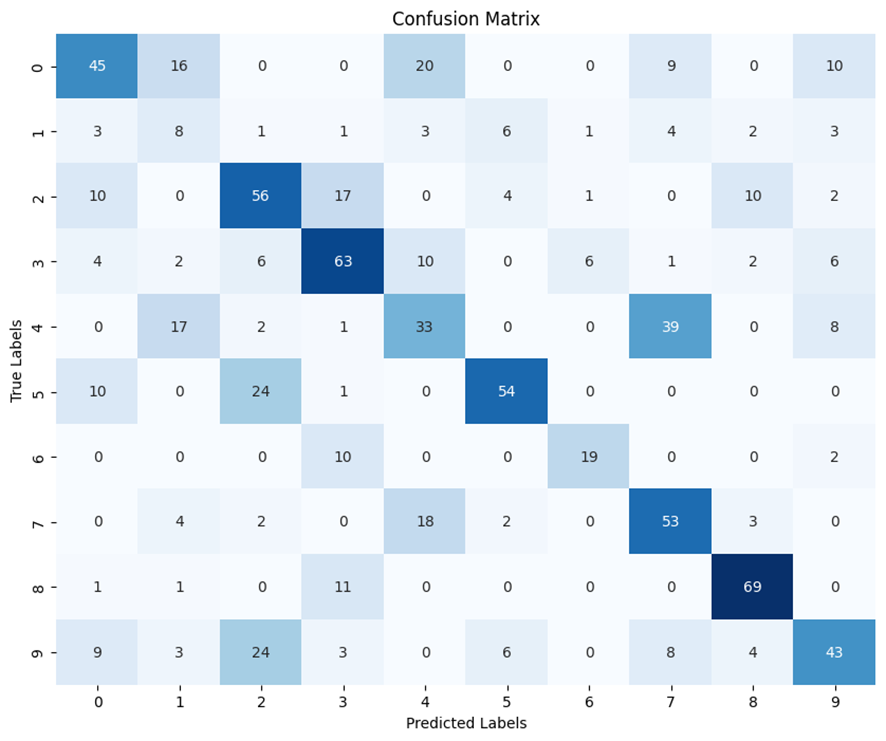|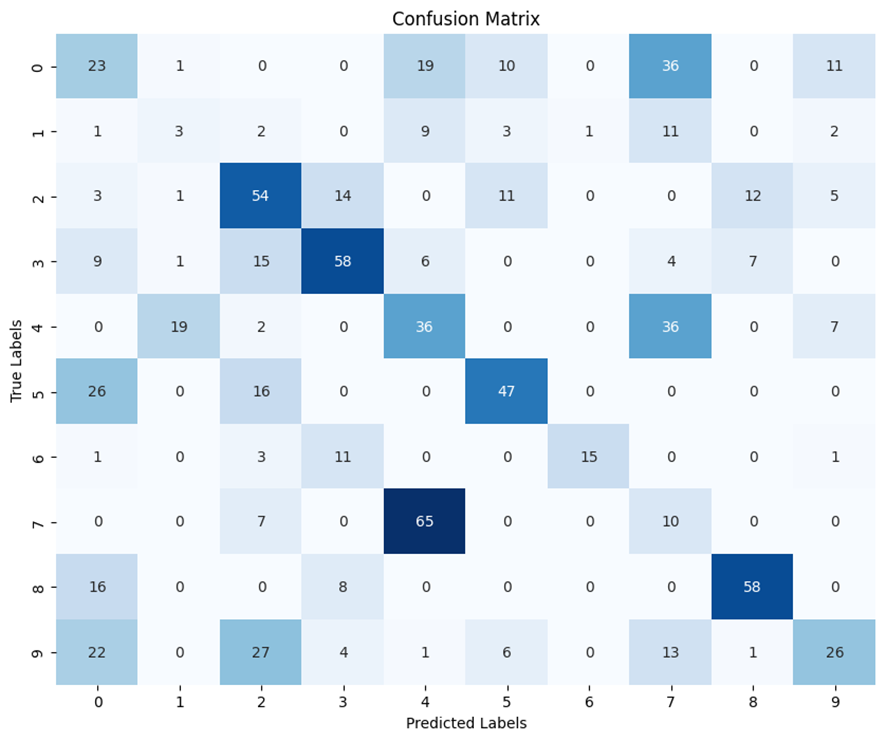|
|loss: 1.4762 - accuracy: 0.6115|loss: 1.4165 - accuracy: 0.5404|loss: 1.5734 - accuracy: 0.5429|loss: 1.5932 - accuracy: 0.4044|

Após implementarmos estas alterações, verificamos uma melhoria no desempenho geral do modelo, resultando numa diminuição da *loss* e num aumento da *accuracy*. Tal evidencia que o modelo beneficiou de um maior tempo de treino e de uma arquitetura mais simples. 

Assim, concluímos que estas mudanças foram eficazes para otimizar os resultados do modelo.

A próxima alteração que testámos consistiu em modificar a função de ativação utilizada em cada camada da rede, substituindo a *ReLU* por alternativas como: *Leaky ReLU* (com alpha=0.001) e *ELU*. Mantivemos constante o valor de penalização (*kernel_regularizer=l2(0.01)*) de forma a avaliar o impacto destas mudanças no desempenho do modelo.

Decidimos testar estas modificações para evitar o problema dos neurónios mortos, comum com a ReLU tradicional. 

# Resultados obtidos: Experiência_8 #

Função de ativação: *Leaky ReLU*

|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|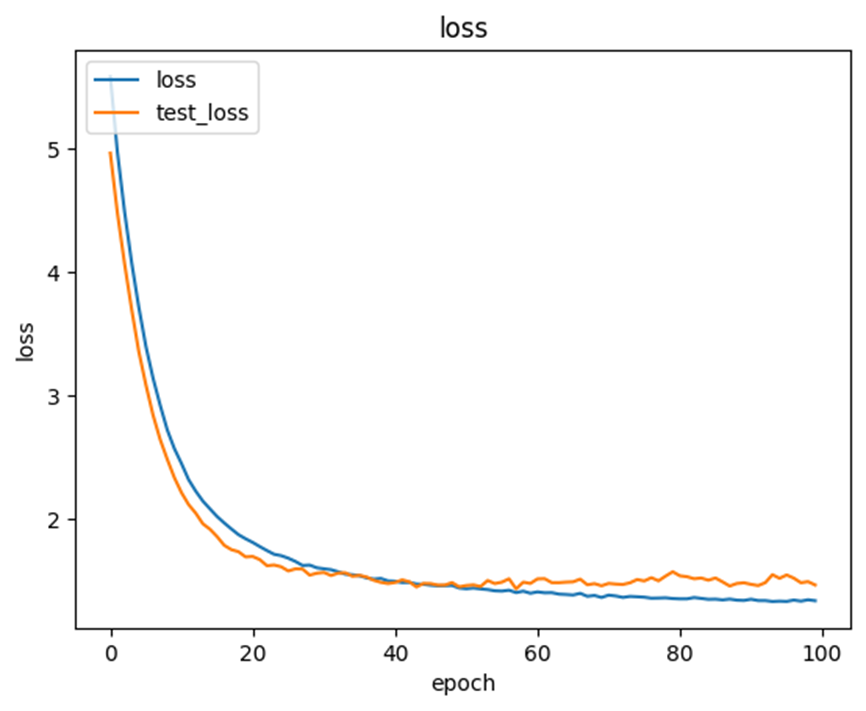|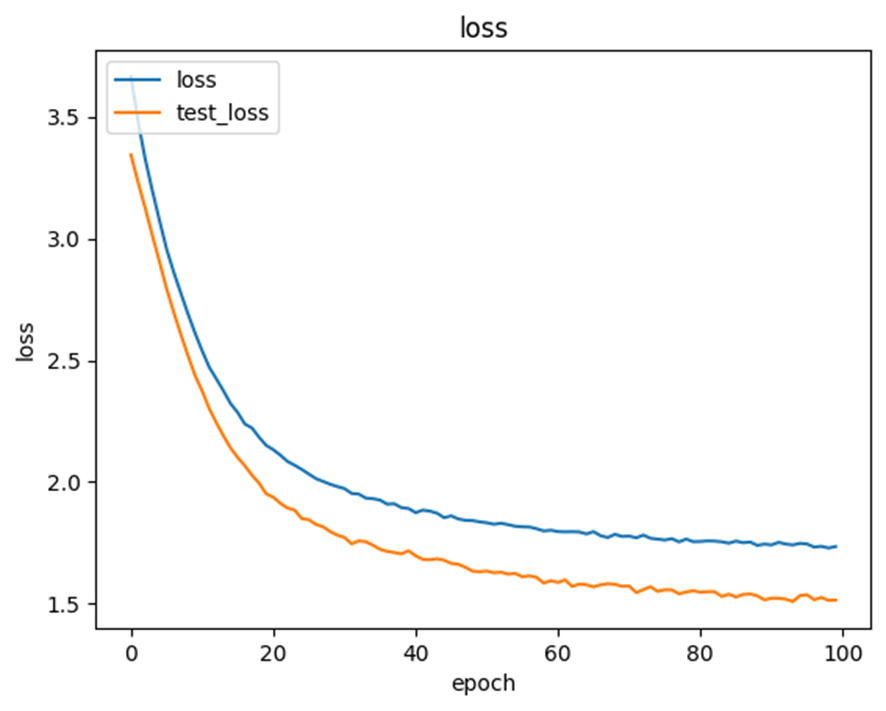|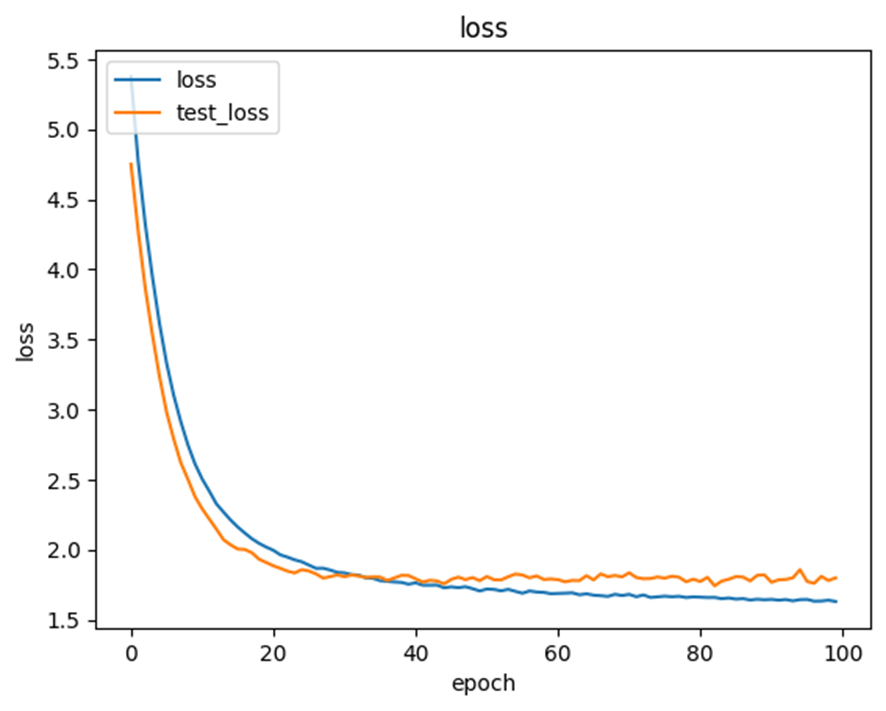|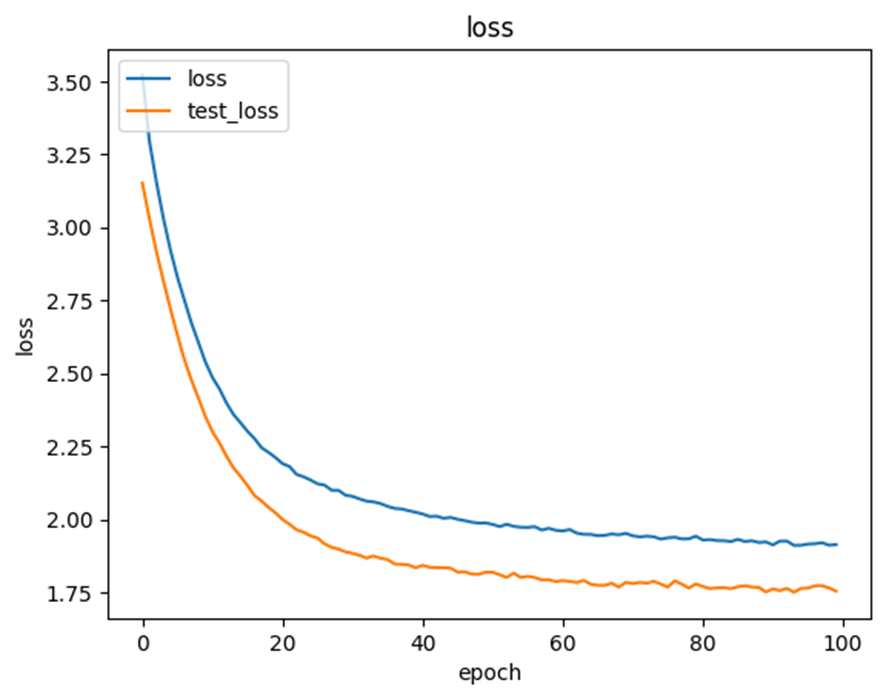|
|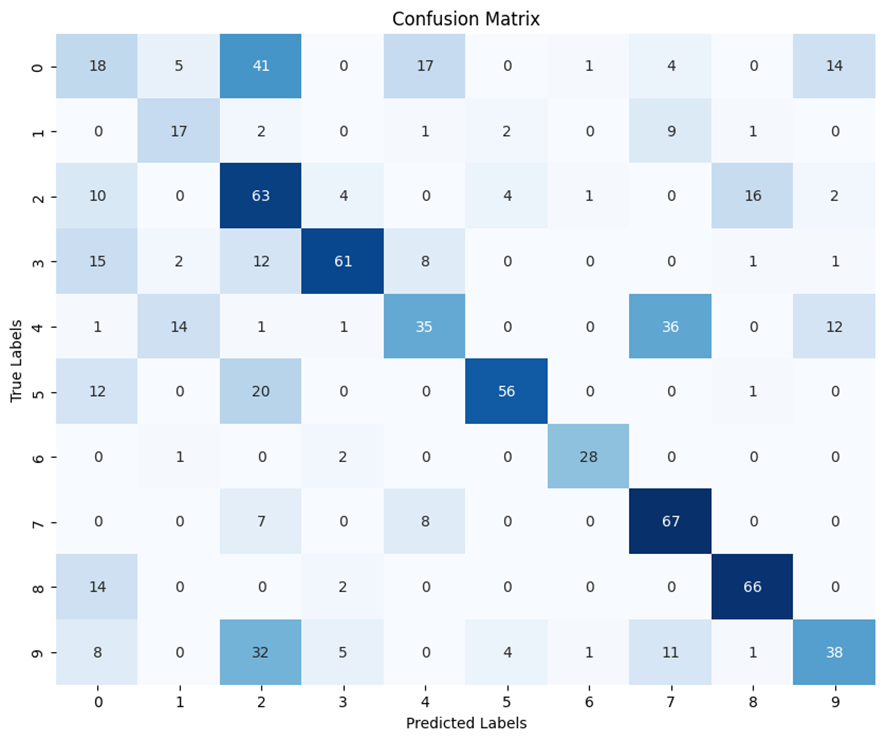|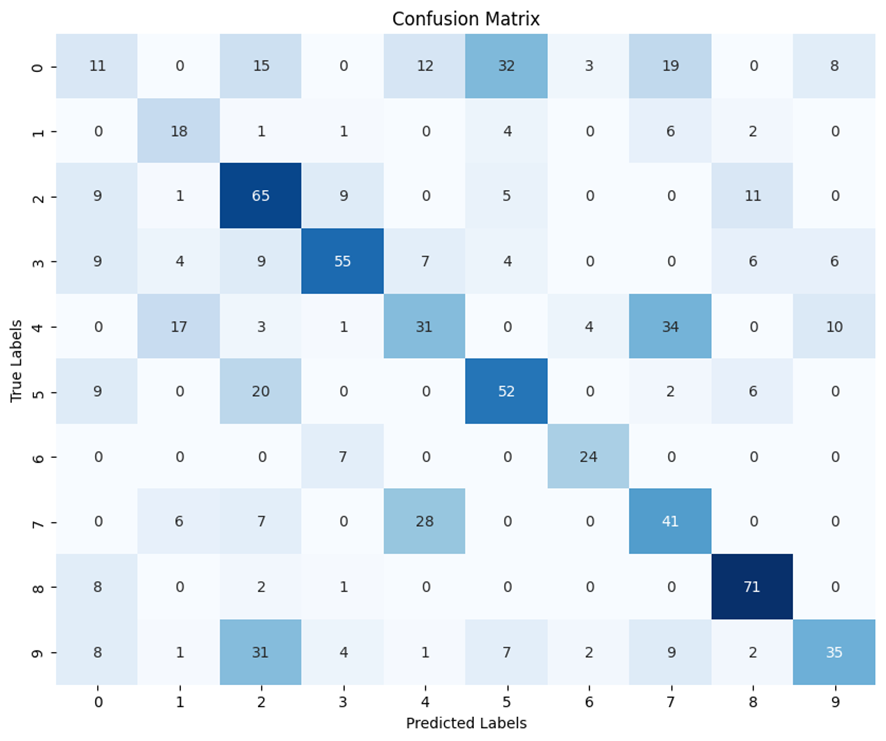|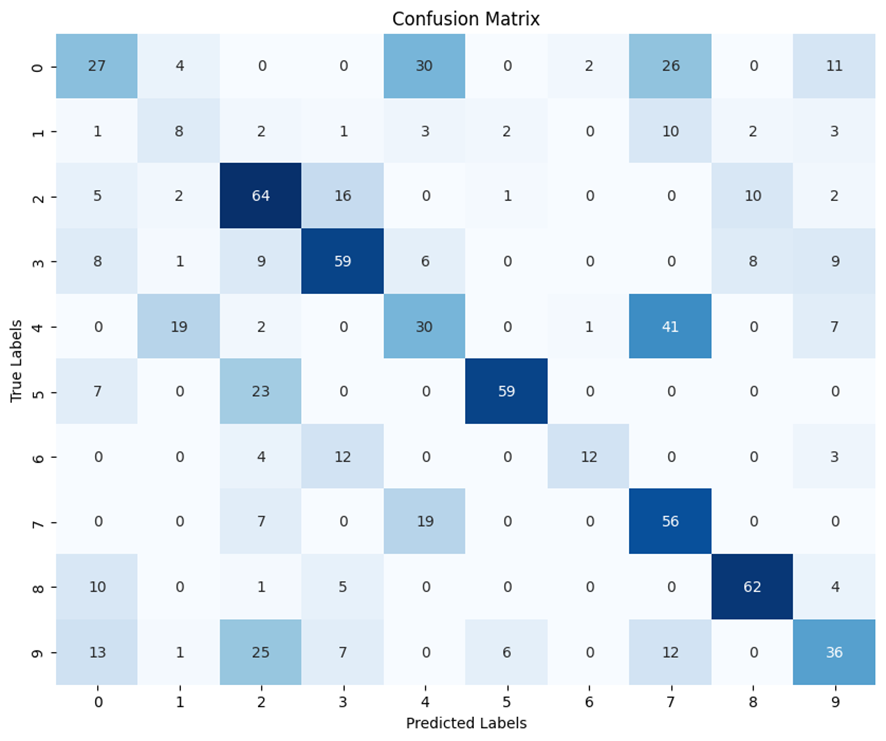|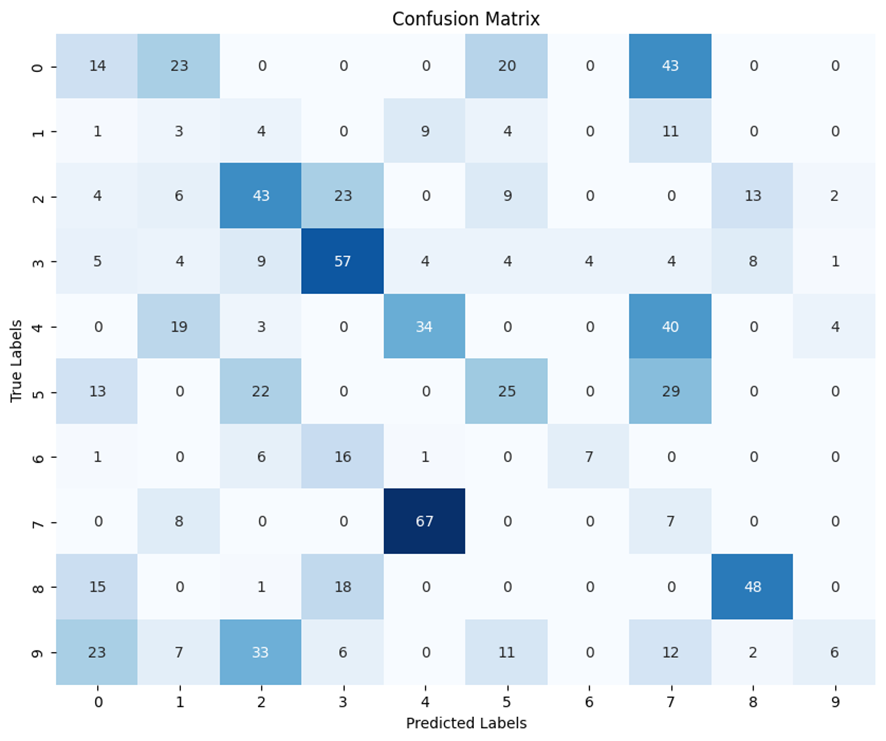|
|loss: 1.4585 - accuracy: 0.5502|loss: 1.5061 - accuracy: 0.4939|loss: 1.5455 - accuracy: 0.5061|loss: 1.6996 - accuracy: 0.2990|

Função de ativação: ELU

|13 coeficientes|13 coeficientes|8 coeficientes|8 coeficientes|
|-------------------|-------------------|-------------------|-------------------|
|   create_mlp()  |    simpler_mlp()  |   create_mlp()    |    simpler_mlp()   |
|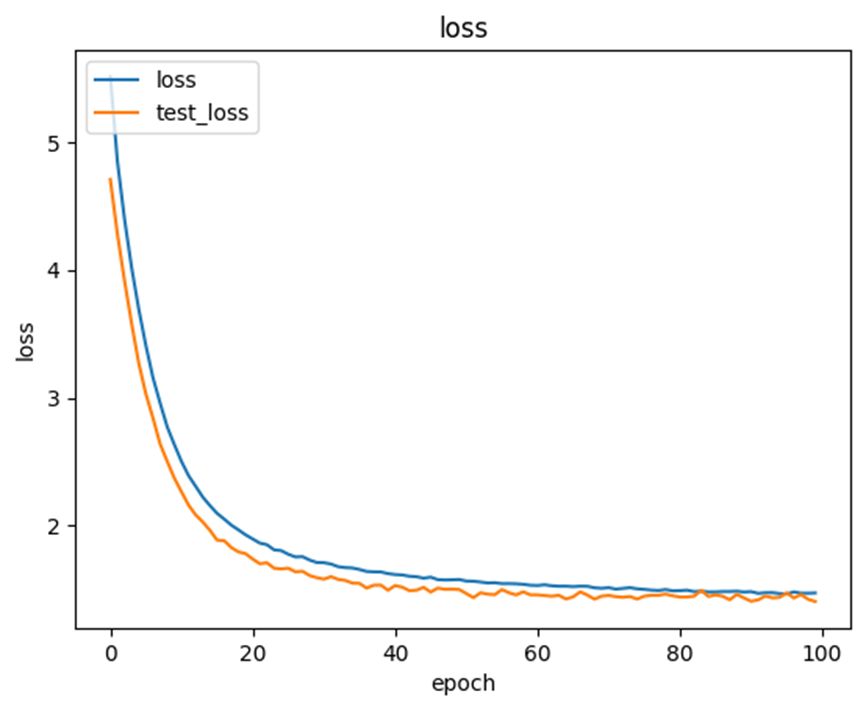|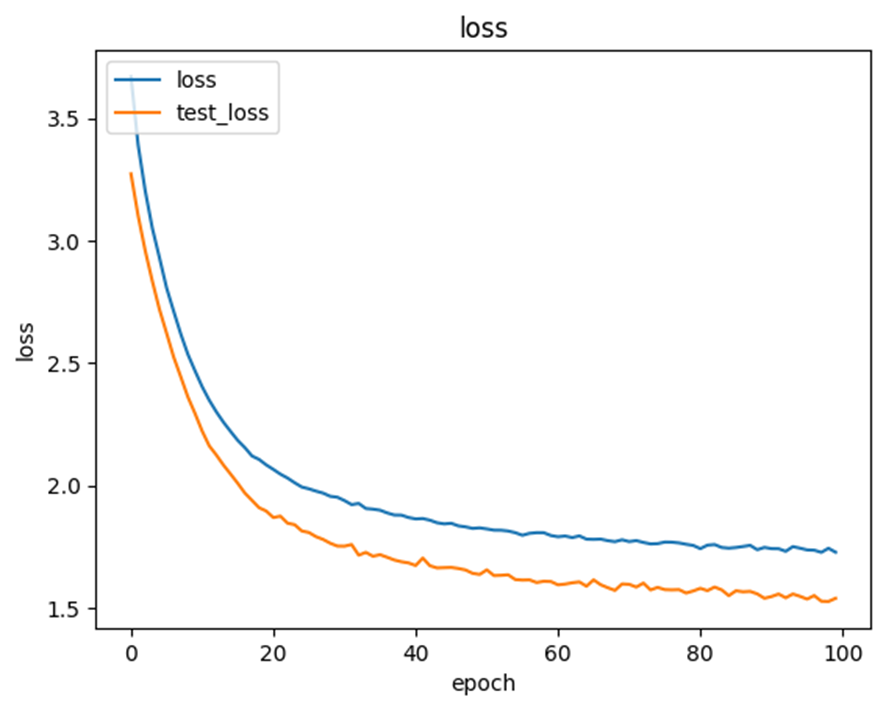|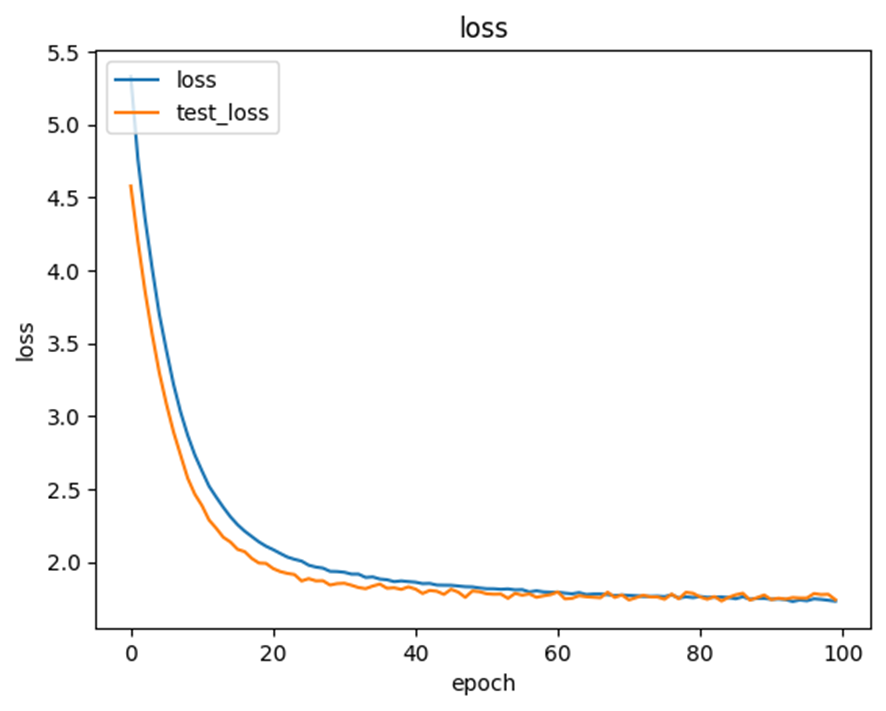|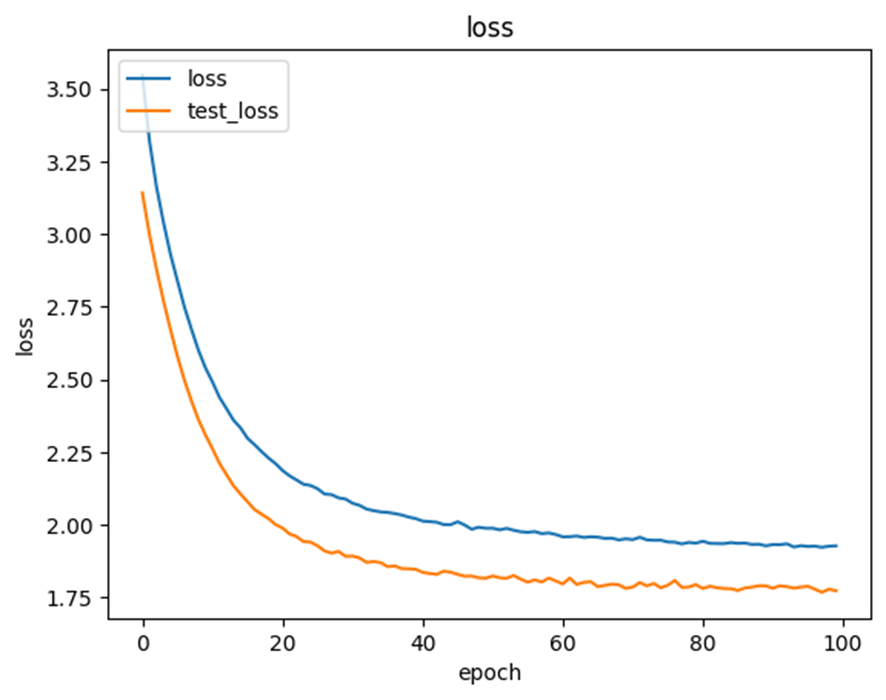|
|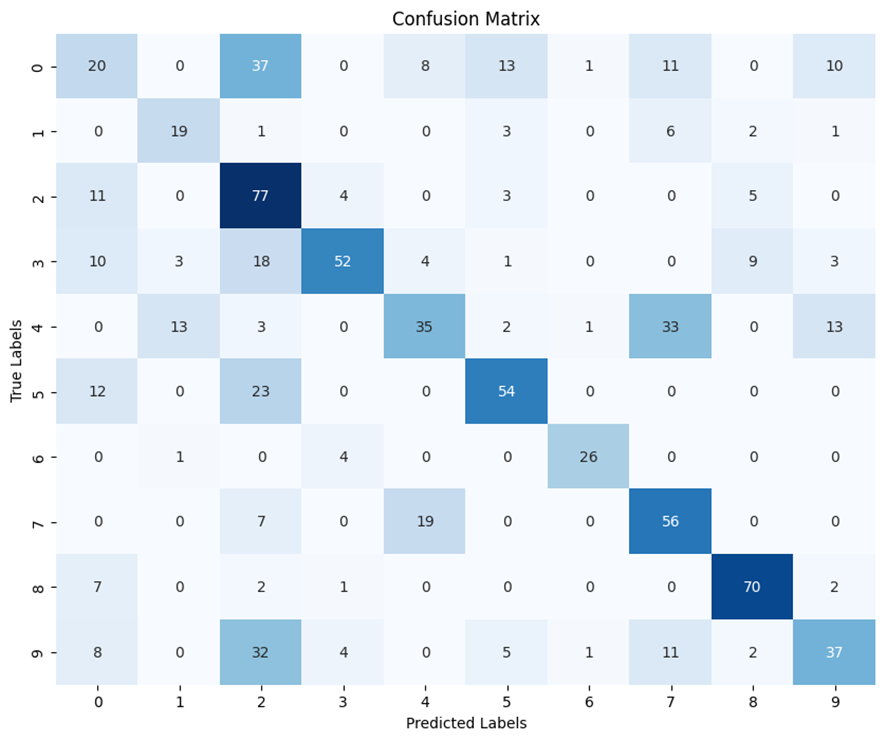|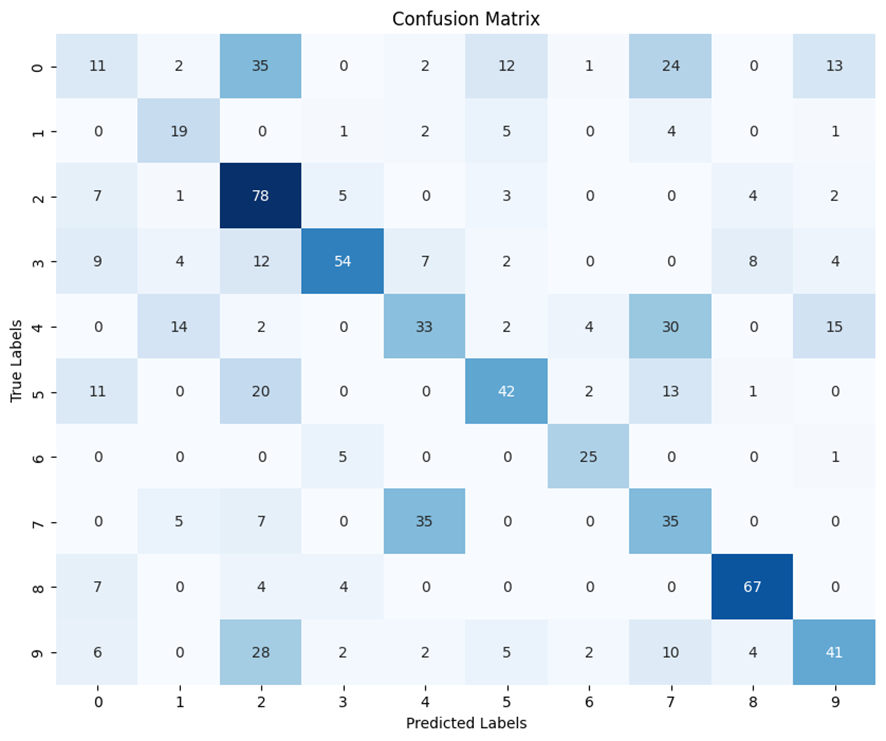|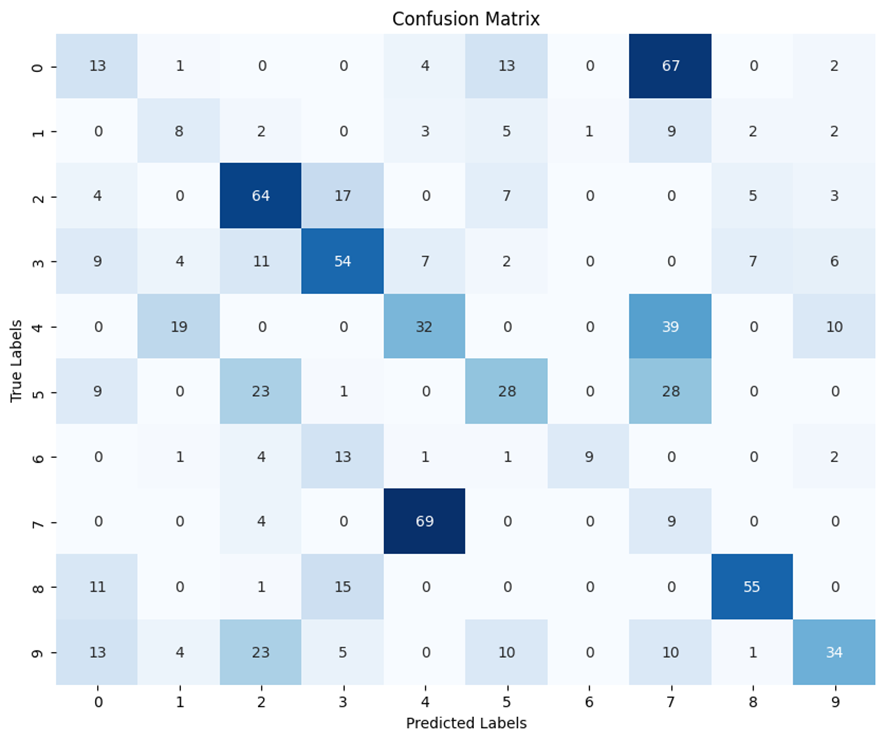|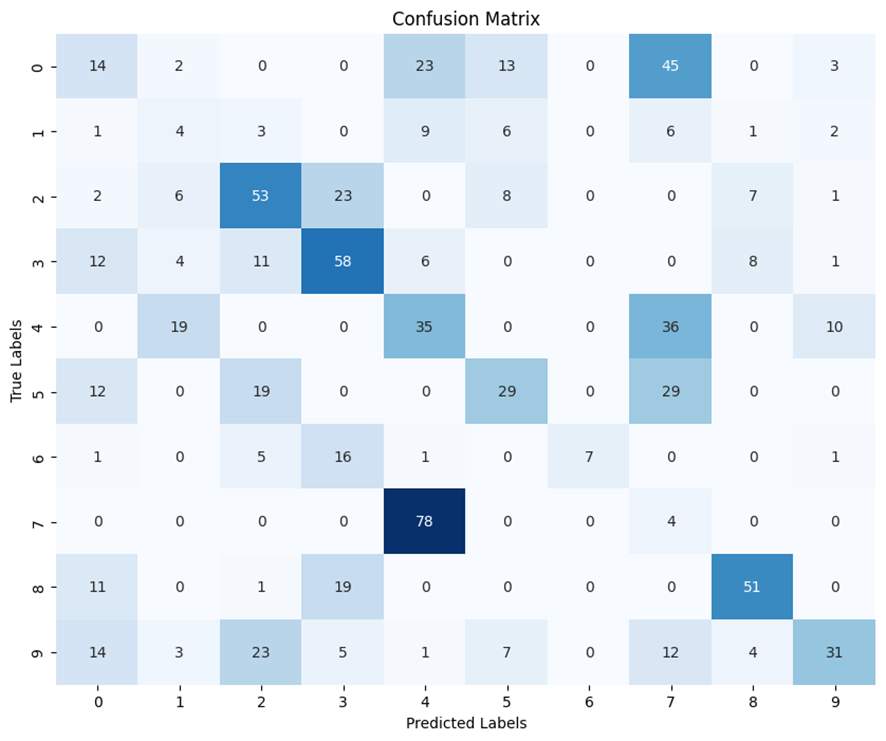|
|loss: 1.4485 - accuracy: 0.5466|loss: 1.5563 - accuracy: 0.4963|loss: 1.6941 - accuracy: 0.3750|loss: 1.7656 - accuracy: 0.3505|

Após a análise dos resultados obtidos, constatámos que a substituição da função de ativação **ReLU** por **Leaky ReLU** e **ELU** não trouxe melhorias ao desempenho do modelo.

Apesar da *loss* diminuir durante o treino, os valores das métricas finais pioraram comparativamente aos obtidos com a ReLU. Além disso, as matrizes de confusão revelam uma classificação menos precisa, evidenciada pela maior dispersão nas previsões.

# ANÁLISE FINAL #

Com base nas experiências realizadas, consideramos que os melhores resultados obtidos foram os observados na **Experiência 7**. 

Deste modo, selecionamos como parâmetros para o modelo final:

- otimizador **Adam** com um **learning rate de 0.0001**, pois este apresentou um equilíbrio adequado entre a convergência da loss e a estabilidade do treino;

- taxa de **dropout de 0.3** em conjunto com **batch normalization** em todas as *Hidden layers*, uma vez que consideramos que esta abordagem garante maior robustez ao modelo e ajuda a mitigar o risco de overfitting;

- **batch size = 32** para cada iteração; 

- arquitetura da rede definida pela função **create_mlp** que inclui:
    - *Input Layer*;
    - 3 *Hidden layers* com **256, 128 e 64 neurónios**, respetivamente e usando **ReLu** como função de ativação;
    - *Output Layer*, usando **softmax** como função de ativação;
    
Optamos também por implementar a técnica de **data augmentation** para enriquecer o conjunto de treino.

Além disso, o modelo final foi configurado para treinar durante **100 epochs**, utilizando o conjunto de dados com **13 coeficientes**, porque como referido anteriomente, esta implementação permitiu-nos obter melhores resultados.

O modelo final pode ser treinado e os respetivos resultados podem ser visualizados, executando as células de código subsequentes.


Processamento dos dados (com *Data Augmentation*)

In [ ]:
# Define funções de data augmentation para MLP

def time_shift(sample, max_shift=10):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(sample, shift, axis=0)

def amplitude_scaling(sample, scale_min=0.5, scale_max=1):
    scale = np.random.uniform(scale_min, scale_max)
    return sample * scale

def preprocess_dataset_aug(dataset_path, train_folds, test_folds, val_folds, num_classes=10, augment=True):
    
    # Carregar o dataset
    with open(dataset_path, 'rb') as file:
        dataset_mlp = pickle.load(file)

    # Converter para array numpy
    dataset_mlp = np.array(dataset_mlp)
    print(f"Shape do dataset: {dataset_mlp.shape}")

    # Inicializar listas necessárias para o treino, teste e validação
    X_train, y_train = [], []
    X_test, y_test = [], []
    X_val, y_val = [], []

    # Preencher dados de treino
    for fold_idx in train_folds:
        data, labels = dataset_mlp[fold_idx]
        for sample, label in zip(data, labels):
            X_train.append(sample)  
            y_train.append(label)

            if augment:
                # Aplicar time_shift
                augmented_sample = time_shift(sample)
                X_train.append(augmented_sample)
                y_train.append(label)

                # Aplicar amplitude_scaling
                augmented_sample = amplitude_scaling(sample)
                X_train.append(augmented_sample)
                y_train.append(label)

    # Preencher dados de teste
    for fold_idx in test_folds:
        data, labels = dataset_mlp[fold_idx]
        X_test.extend(data)
        y_test.extend(labels)

    # Preencher dados de validação
    for fold_idx in val_folds:
        data, labels = dataset_mlp[fold_idx]
        X_val.extend(data)
        y_val.extend(labels)

    # Converter para arrays numpy 
    X_train = np.array(X_train).astype(float)
    y_train = np.array(y_train)
    X_test = np.array(X_test).astype(float)
    y_test = np.array(y_test)
    X_val = np.array(X_val).astype(float)
    y_val = np.array(y_val)

    # Codificar as labels como inteiros
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.transform(y_test)
    y_val = encoder.transform(y_val)

    # Criar mapeamento de classes
    class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    print("Mapeamento de classes:", class_mapping)

    # Normalizar as features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    print(f"Shape de X_train: {X_train.shape}")
    print(f"Shape de X_test: {X_test.shape}")
    print(f"Shape de X_val: {X_val.shape}")

    return X_train, y_train, X_test, y_test, X_val, y_val

Funções para definir, compilar e treinar o modelo MLP

In [ ]:
# Definir a MLP
def create_mlp(input_shape, num_classes):
    model = models.Sequential()

    #Input Layer
    model.add(layers.InputLayer(input_shape=input_shape))

    #Hidden Layers
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))) 
    model.add(BatchNormalization())  
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  
    model.add(BatchNormalization())  
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  
    model.add(BatchNormalization())  
    model.add(layers.Dropout(0.3))

    #Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


def compile_mlp(model):
    # Compilar o modelo
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Exibir o resumo do modelo
    model.summary()

    return model

def train_mlp(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):

    # Calcular os pesos de classe
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    

    class_weight_dict = dict(enumerate(class_weights))
    

    print("Pesos calculados para cada classe:", class_weight_dict)

    # Treinar o modelo com os pesos de classe
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight_dict 
    )

    return history

Função para representar os gráficos

In [ ]:
def plot_training_history_and_evaluate(history, model, X_test, y_test):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','test_loss'], loc='upper left')
    plt.show()

    # Avaliar o modelo nos dados de teste
    scores = model.evaluate(X_test, y_test)
    print("Test accuracy:", scores[1])

    # Gerar previsões no conjunto de teste
    y_test_pred_probs = model.predict(X_test)  
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)  
    y_test_true = y_test  

    # Gerar matriz de confusão
    cm = confusion_matrix(y_test_true, y_test_pred)
    print("Matriz de Confusão:")
    print(cm)

    # Relatório de classificação
    print("Relatório de Classificação:")
    print(classification_report(y_test_true, y_test_pred))

    # Plotar matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


Treinar o modelo

In [ ]:
dataset_path = 'dataset_mlp.pkl'
train_folds = [0, 1, 2, 3, 4, 5, 6, 7]
test_folds = [8]
val_folds = [9]

X_train, y_train, X_test, y_test, X_val, y_val = preprocess_dataset_aug(
    dataset_path, train_folds, test_folds, val_folds
)

#Limpar sessões anteriores
tf.keras.backend.clear_session()

num_classes = 10
input_shape_mlp = (39,)

# Construir o modelo
mlp_model = create_mlp(input_shape_mlp, num_classes)

# Compilar e exibir o resumo do modelo
mlp_model = compile_mlp(mlp_model)

Shape do dataset: (10, 2)
Mapeamento de classes: {'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2, 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5, 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}
Shape de X_train: (21237, 39)
Shape de X_test: (816, 39)
Shape de X_val: (837, 39)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10240     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normaliz

In [6]:
# Treinar o modelo
history = train_mlp(mlp_model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32)

Pesos calculados para cada classe: {0: 0.884875, 1: 1.9447802197802198, 2: 0.884875, 3: 0.884875, 4: 0.884875, 5: 0.8654034229828851, 6: 2.2762057877813504, 7: 0.8611922141119221, 8: 0.9265706806282723, 9: 0.884875}
Epoch 1/100
664/664 [==============================] - 1s 2ms/step - loss: 5.8639 - accuracy: 0.1529 - val_loss: 4.9783 - val_accuracy: 0.3692
Epoch 2/100
664/664 [==============================] - 1s 1ms/step - loss: 5.2724 - accuracy: 0.2211 - val_loss: 4.6598 - val_accuracy: 0.3608
Epoch 3/100
664/664 [==============================] - 1s 1ms/step - loss: 4.8863 - accuracy: 0.2621 - val_loss: 4.3500 - val_accuracy: 0.3680
Epoch 4/100
664/664 [==============================] - 1s 1ms/step - loss: 4.5487 - accuracy: 0.2893 - val_loss: 4.0802 - val_accuracy: 0.3775
Epoch 5/100
664/664 [==============================] - 1s 2ms/step - loss: 4.2412 - accuracy: 0.3095 - val_loss: 3.8245 - val_accuracy: 0.4110
Epoch 6/100
664/664 [==============================] - 1s 2ms/step - 

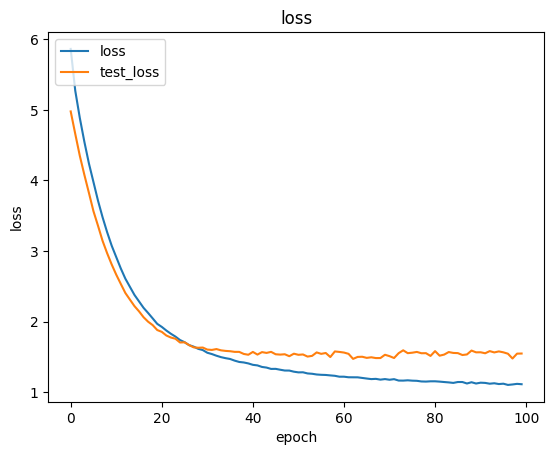

26/26 [==============================] - 0s 230us/step - loss: 1.4771 - accuracy: 0.5919
Test accuracy: 0.591911792755127
Matriz de Confusão:
[[36  9 25  0 13  2  0  0  0 15]
 [ 0 17  0  0  2  1  0 10  1  1]
 [ 7  0 64 11  0  6  1  0 11  0]
 [13  1  8 59  7  0  3  0  1  8]
 [ 3  8  4  0 37 11  1 32  0  4]
 [ 1  4 27  0  0 56  0  0  1  0]
 [ 0  1  0  0  0  0 30  0  0  0]
 [ 0  0  7  0  9  0  0 66  0  0]
 [ 2  1  1  3  0  0  0  0 75  0]
 [ 8  0 26  6  2  1  2 11  1 43]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.51      0.36      0.42       100
           1       0.41      0.53      0.47        32
           2       0.40      0.64      0.49       100
           3       0.75      0.59      0.66       100
           4       0.53      0.37      0.44       100
           5       0.73      0.63      0.67        89
           6       0.81      0.97      0.88        31
           7       0.55      0.80      0.66        82
           8

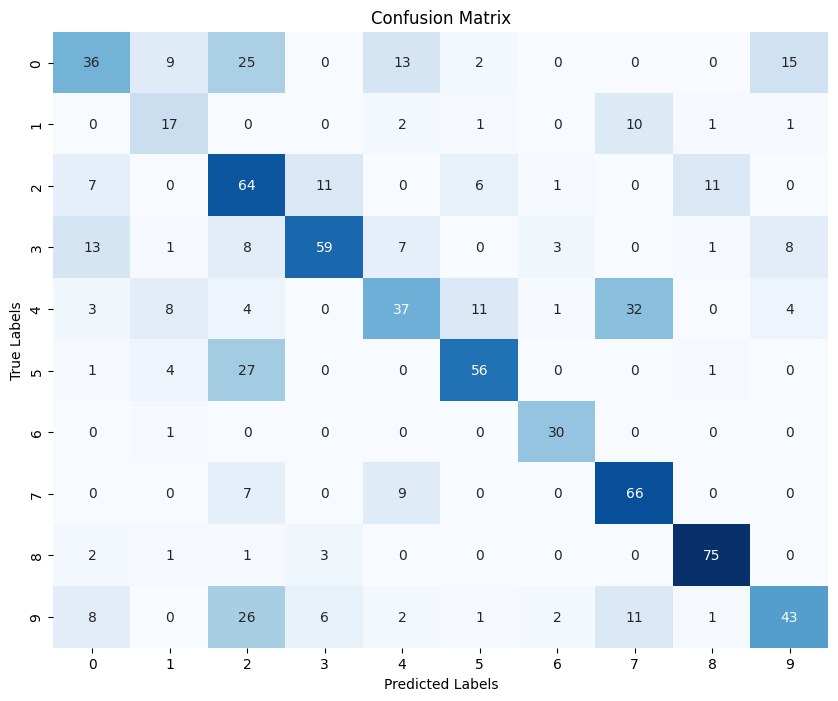

In [7]:
# Plotar histórico de perda e avaliar o modelo
plot_training_history_and_evaluate(history, mlp_model, X_test, y_test)

Através  da análise destas métricas percebemos que o modelo MLP aprensenta resultados sólidos e satifatórios para a classificação dos sons do nosso Dataset.

Apesar de ainda existirem áreas para melhoria, conseguimos destacar diversos aspetos:

- o modelo alcançou uma accuracy de 59%, indicando que é capaz de identificar corretamente a maioria das classes;

- as métricas precision, recall e f1-score refletem um desempenho equilibrado, com uma tendência para evitar falsos negativos;

- as classes 5, 6 e 7 tiveram um desempenho muito positivo, mostrando a eficácia do modelo em identificar padrões;

- as classes 0, 1 e 4 mostram um desempenho inferior, com valores de f1-score mais baixos, quando comparados com as restantes classes.

De um modo geral, o nosso modelo demonstrou uma boa capacidade de generalização, refletindo um desempenho promissor. Assim, percebemos que este consegue capturar padrões complexos dos sons urbanos, tendo por isso uma boa capacidade para lidar com a diversidade dos mesmos.


# Bonus - Deepfool

In [ ]:
def deepfool_attack(model, X, y, epsilon=0.01):
    confidences = []

    for i in tqdm(range(len(X))):
        sample = X[i].reshape(1, -1) 
        label = y[i]

        confidence = model.predict(sample, verbose=0)
        true_value = confidence[0][label]

        epsilons = [0, 0.01, 0.1, 0.15]

        adv_values = [true_value]

        for eps in epsilons:
            
            perturbation = epsilon * np.sign(np.random.randn(*sample.shape)) 
            adv_x = sample + perturbation * eps
            adv_x = np.clip(adv_x, 0, 1)  
            
            confidence_adv = model.predict(adv_x, verbose=0)
            confidence_adv_max_value = confidence_adv[0][label]
            adv_values.append(confidence_adv_max_value)

        confidences.append((epsilons, adv_values))

    return confidences

In [ ]:

def plot_confidences(confidences, y_test_subset):
    for i, (epsilons, adv_values) in enumerate(confidences):
        plt.figure(figsize=(10, 5))
        epsilons = [-0.05] + epsilons 
        adv_values = [adv_values[0]] + adv_values[1:]

        plt.plot(epsilons, adv_values, marker='o')
        plt.xlabel('epsilon')
        plt.xticks(epsilons)
        plt.ylabel('Confidence')
        plt.ylim(0, 1)
        plt.title(f'Confidence of adversarial examples for sample in label {y_test_subset[i]}')
        plt.show()

Shape do dataset: (10, 2)
Mapeamento de classes: {'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2, 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5, 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}
Shape de X_train: (21237, 39)
Shape de X_test: (816, 39)
Shape de X_val: (837, 39)


100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


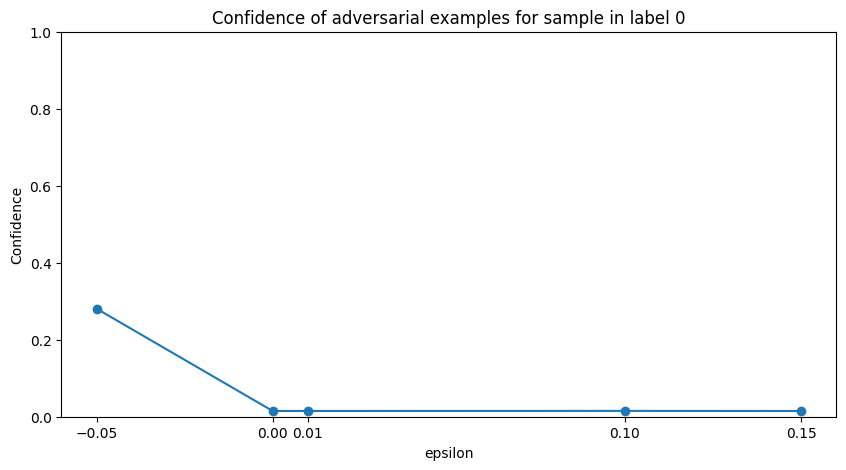

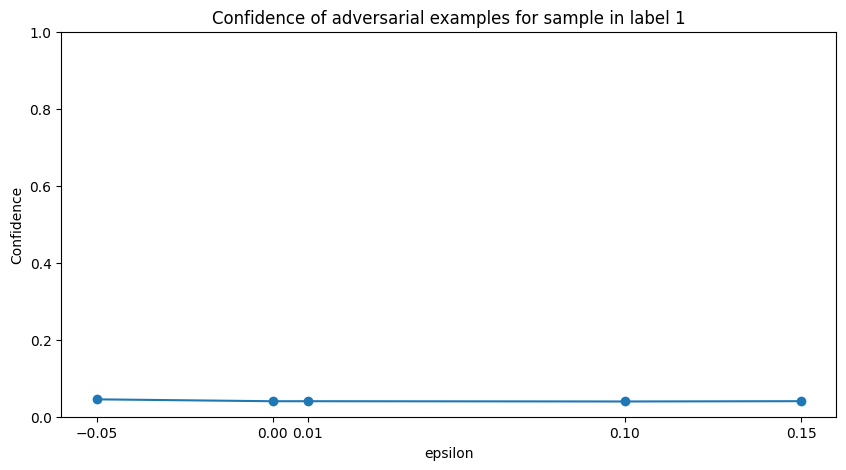

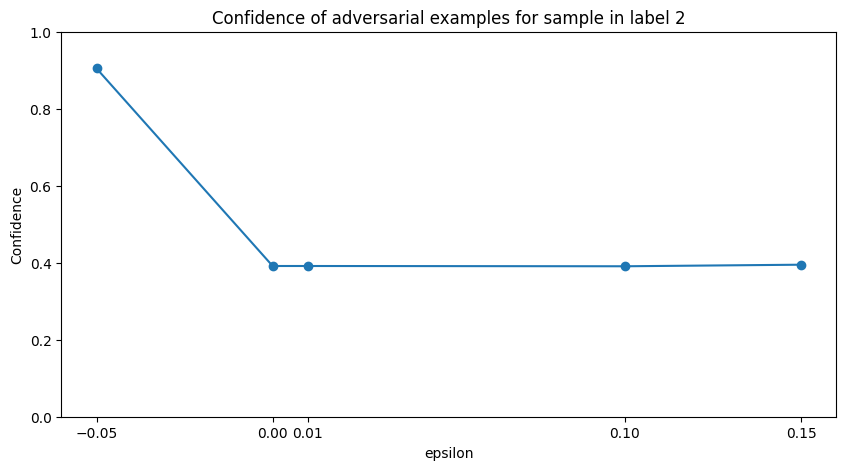

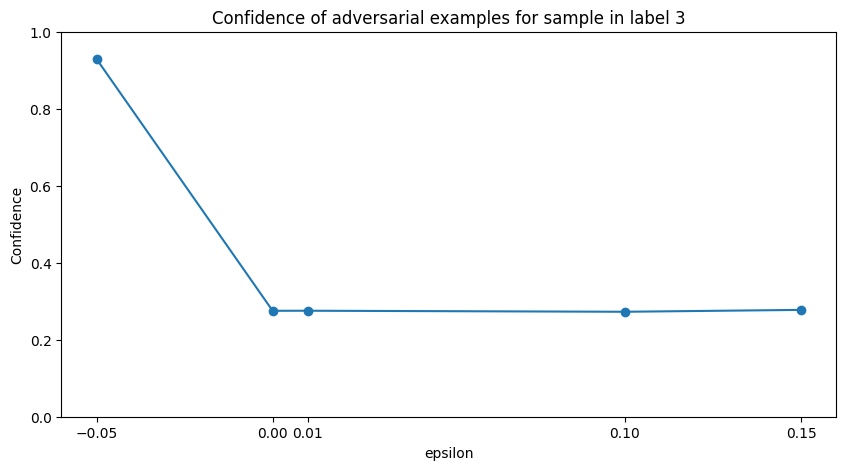

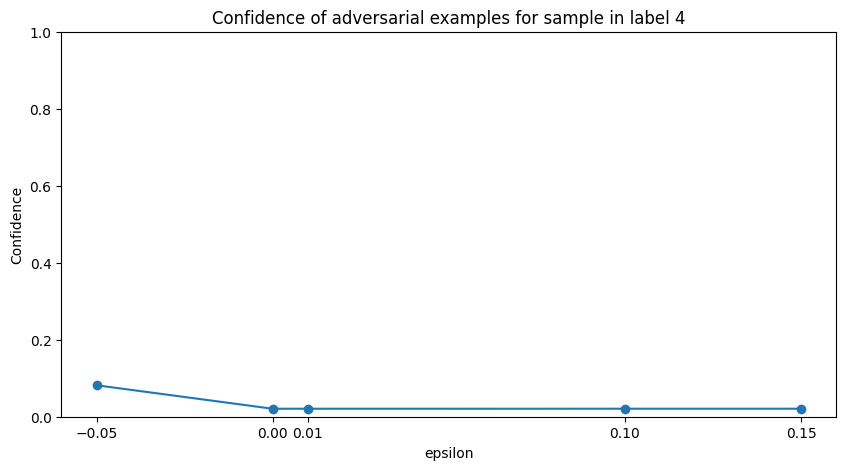

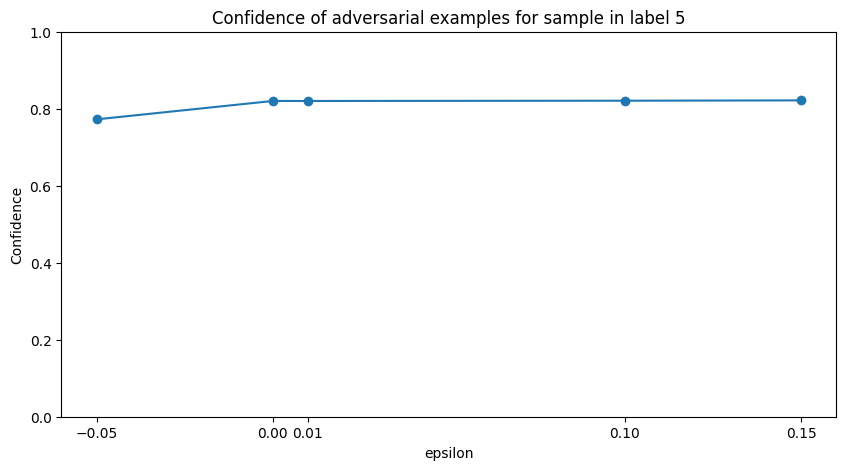

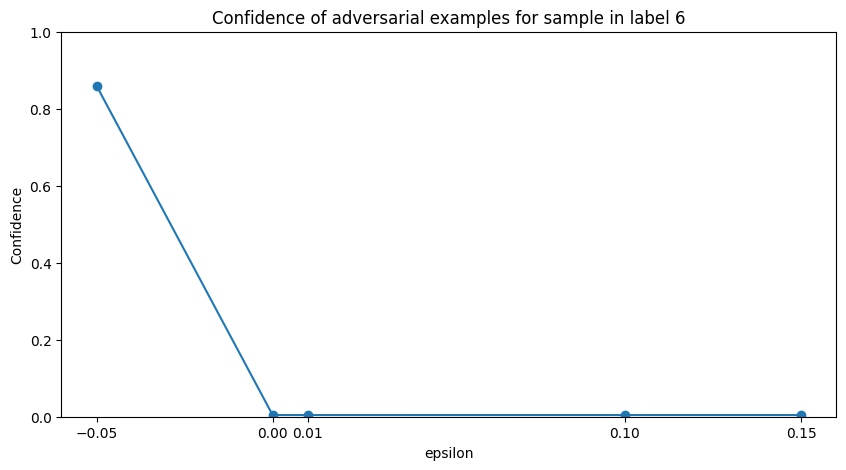

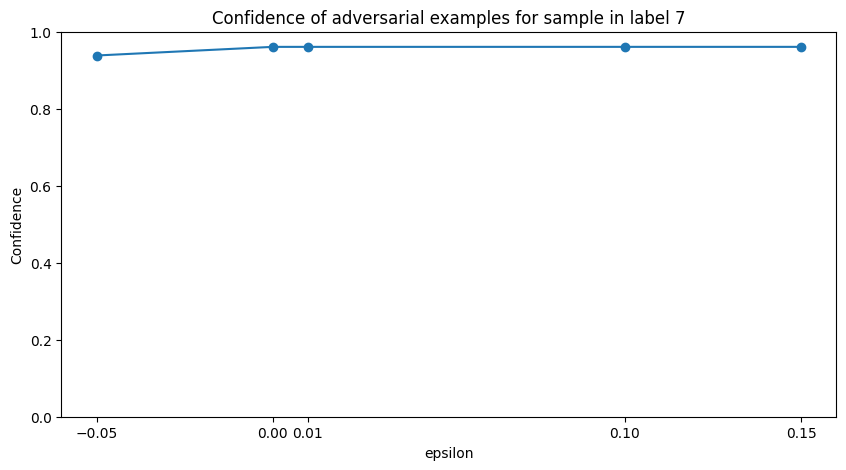

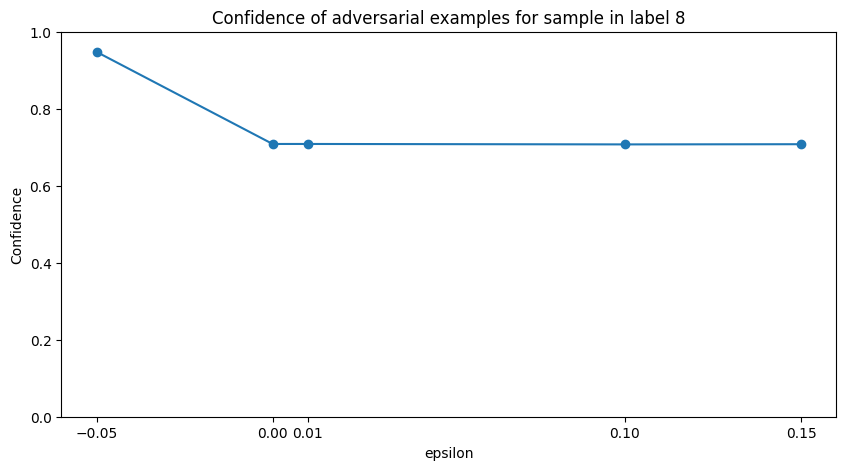

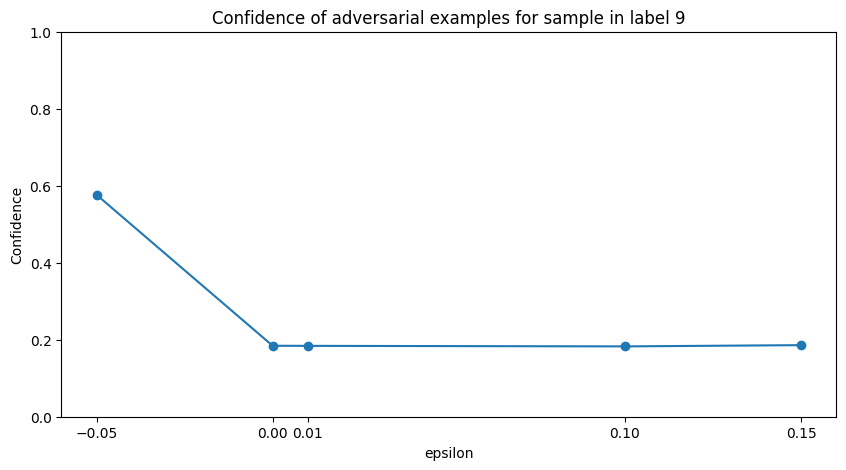

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val = preprocess_dataset_aug('dataset_mlp.pkl', [0, 1, 2, 3, 4, 5, 6, 7], [8], [9])
model = load_model("mlp.h5")

# Mapeamento de classes 
class_mapping = {'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2,
                 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5,
                 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}

X_test_subset = []
y_test_subset = []

for label in class_mapping.values():
    
    indices = np.where(y_test == label)[0]
    selected_index = np.random.choice(indices)
    X_test_subset.append(X_test[selected_index])
    y_test_subset.append(y_test[selected_index])

X_test_subset = np.array(X_test_subset)
y_test_subset = np.array(y_test_subset)

confidences = deepfool_attack(model, X_test_subset, y_test_subset, epsilon=0.01)

plot_confidences(confidences, y_test_subset)

A partir dos níveis de confiança observados para as diferentes classes, podemos concluir que a robustez do modelo varia significativamente, de classe para classe. Isto indica que o modelo tem um desempenho desigual entre as classes.